# NBA Dataset - Sistemas Basados en el Conocimiento

In [53]:
#Librerías

import numpy as np
import pandas as pd
import seaborn as sns
import pydot
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score, recall_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_predict
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import RandomizedSearchCV
from skopt import BayesSearchCV
import time

In [54]:
#Carga de Datos
nba_data = pd.read_csv("all_seasons.csv")
nba_data.head()

Unnamed: 0       player_name team_abbreviation   age  player_height  \
0           0  Randy Livingston               HOU  22.0         193.04   
1           1  Gaylon Nickerson               WAS  28.0         190.50   
2           2      George Lynch               VAN  26.0         203.20   
3           3    George McCloud               LAL  30.0         203.20   
4           4      George Zidek               DEN  23.0         213.36   

   player_weight                college country draft_year draft_round  ...  \
0      94.800728        Louisiana State     USA       1996           2  ...   
1      86.182480  Northwestern Oklahoma     USA       1994           2  ...   
2     103.418976         North Carolina     USA       1993           1  ...   
3     102.058200          Florida State     USA       1989           1  ...   
4     119.748288                   UCLA     USA       1995           1  ...   

    pts  reb  ast  net_rating  oreb_pct  dreb_pct  usg_pct  ts_pct  ast_pct  \
0   3.9  1.5  2.4         0.3     0.042     0.071    0.169   0.487    0.248   
1   3.8  1.3  0.3         8.9     0.030     0.111    0.174   0.497    0.043   
2   8.3  6.4  1.9        -8.2     0.106     0.185    0.175   0.512    0.125   
3  10.2  2.8  1.7        -2.7     0.027     0.111    0.206   0.527    0.125   
4   2.8  1.7  0.3       -14.1     0.102     0.169    0.195   0.500    0.064   

    season  
0  1996-97  
1  1996-97  
2  1996-97  
3  1996-97  
4  1996-97  

[5 rows x 22 columns]

# Procesado Inicial

Para empezar, vamos a dedicarnos a tratar los datos. Antes de todo querremos limpiarlos, solucionando así problemas que pueden surgir en función del tipo de datos que tengamos o de como estén distribuidos y luego nos encargaremos de explorarlos y entenderlos mejor para ver que es lo más interesante a explorar.

In [55]:
#Valores nulos nba_data
count_null = nba_data.isnull().sum()
print(count_null)

Unnamed: 0              0
player_name             0
team_abbreviation       0
age                     0
player_height           0
player_weight           0
college              1854
country                 0
draft_year              0
draft_round             0
draft_number            0
gp                      0
pts                     0
reb                     0
ast                     0
net_rating              0
oreb_pct                0
dreb_pct                0
usg_pct                 0
ts_pct                  0
ast_pct                 0
season                  0
dtype: int64


**Valores Nulos**

Para empezar, vamos a eliminar las columnas categóricas que no aportan demasiada información. Una de ellas es college, que tiene bastantes valores nulos:

Esto se debe a que no todos los jugadores que llegan a la NBA tienen un previo paso por universidades, de hecho, la mayoría de los no americanos, llegan a la liga desde ligas profesionales y sin previo paso por la universidad. Ahora empieza a darse la situación que también jugadores americanos no van a la universidad y juegan en una liga semiprofesional americana llamada NBA G League Ignite, donde forman a jóvenes talentos. Además, la normativa sobre la edad mínima ha ido cambiando, Kobe Bryant fue directamente desde el instituto a la NBA porque en su época estaba permitido. Otro ejemplo de jugador que no ha pasado por la universidad es Luka Doncic, de los mejores jugadores de la liga y que viene directamente del Real Madrid.

Sabiendo esto, y teniendo en cuenta que lo último que queremos hacer es eliminar jugadores que pueden tener mucho valor, creo que lo que tiene más sentido es eliminar la columna de college.

**Otras variables Categóricas**

Luego tenemos la variable name, que no nos hará falta, de momento, no queremos analizar las estadísticas de ningún jugador en concreto y, por otro lado, la variable 'country'. El país tampoco nos dará demasiada información de cara al estudio que queremos hacer, y menos, viendo como nos dan los datos de país, siendo todos de tipo texto. Años atrás la NBA era una liga principalmente americana, donde los internacionales eran 'rara avis' pero vamos a analizar sobre todo datos de los últimos años donde la cantidad de jugadores internacionales ha aumentado muchísimo y su importancia en la liga también, 4 de los últimos 5 MVPs no son americanos. Así que, bajo mi punto de vista, no tiene demasiado sentido tener en cuenta esta información.

Tampoco hace falta la variable unnamed, que son etiquetas numéricas de cada jugador que no aportan información.

Por último, tenemos el 'team_abbreviation', que nos da información sobre el equipo en el que juega ese jugador. Siempre se dice que la NBA es una de las ligas más igualadas del mundo gracias a su sistema de draft, los últimos, reciben a los mejores jugadores jóvenes, y de esta manera se busca equilibrar la liga, así que creo que a la larga tus estadísticas de juego no deberían depender en exceso de en que equipo juegues.

In [56]:
delete = ['player_name','college', 'country','team_abbreviation','Unnamed: 0']
nba_clean = nba_data.drop(columns = delete)
nba_clean.head()

age  player_height  player_weight draft_year draft_round draft_number  gp  \
0  22.0         193.04      94.800728       1996           2           42  64   
1  28.0         190.50      86.182480       1994           2           34   4   
2  26.0         203.20     103.418976       1993           1           12  41   
3  30.0         203.20     102.058200       1989           1            7  64   
4  23.0         213.36     119.748288       1995           1           22  52   

    pts  reb  ast  net_rating  oreb_pct  dreb_pct  usg_pct  ts_pct  ast_pct  \
0   3.9  1.5  2.4         0.3     0.042     0.071    0.169   0.487    0.248   
1   3.8  1.3  0.3         8.9     0.030     0.111    0.174   0.497    0.043   
2   8.3  6.4  1.9        -8.2     0.106     0.185    0.175   0.512    0.125   
3  10.2  2.8  1.7        -2.7     0.027     0.111    0.206   0.527    0.125   
4   2.8  1.7  0.3       -14.1     0.102     0.169    0.195   0.500    0.064   

    season  
0  1996-97  
1  1996-97  
2  1996-97  
3  1996-97  
4  1996-97

También hará falta tratar los datos de las columnas 'draft_year', 'draft_round', 'draft_number' y 'season', ya que en las 3 primeras existen datos de tipo texto y en la última tenemos las temporadas también con un carácter que nos puede traer problemas (-).

Empezando con los datos de la columna season, lo que haremos es transformarlos a 'integers' después de eliminar todos excepto los últimos tres caracteres. De esta manera nos quedará el año en el que la temporada acabó, y tendremos que ser conscientes de ello cuando analicemos los datos.

La temporada 2020-21 ahora es la temporada 21.

In [57]:
nba_clean['season'] = nba_clean['season'].str[-2:].astype(int)
nba_clean.head()

age  player_height  player_weight draft_year draft_round draft_number  gp  \
0  22.0         193.04      94.800728       1996           2           42  64   
1  28.0         190.50      86.182480       1994           2           34   4   
2  26.0         203.20     103.418976       1993           1           12  41   
3  30.0         203.20     102.058200       1989           1            7  64   
4  23.0         213.36     119.748288       1995           1           22  52   

    pts  reb  ast  net_rating  oreb_pct  dreb_pct  usg_pct  ts_pct  ast_pct  \
0   3.9  1.5  2.4         0.3     0.042     0.071    0.169   0.487    0.248   
1   3.8  1.3  0.3         8.9     0.030     0.111    0.174   0.497    0.043   
2   8.3  6.4  1.9        -8.2     0.106     0.185    0.175   0.512    0.125   
3  10.2  2.8  1.7        -2.7     0.027     0.111    0.206   0.527    0.125   
4   2.8  1.7  0.3       -14.1     0.102     0.169    0.195   0.500    0.064   

   season  
0      97  
1      97  
2      97  
3      97  
4      97

Analizando los datos de los undrafted, vemos que aunque los años tienen algunos valores, tanto la ronda como los números son todos iguales, y tenemos, 2414 valores.

Visto esto, vamos a tratar a todos los jugadores que no han sido drafteados como jugadores que son de tercera ronda (en la NBA, el draft solo tiene dos rondas) y vamos a decir que su número del draft va a ser igual a 61 (cada ronda tiene 30 jugadores, es decir, cada año el draft lo forman 60), de esta manera les asignaremos un valor numérico que los colocará por debajo de los que si han sido drafteados y no hará diferencia entre ellos.

In [58]:
nba_clean[nba_clean['draft_number'] == 'Undrafted']

age  player_height  player_weight draft_year draft_round draft_number  \
25     29.0         193.04      86.182480       1992   Undrafted    Undrafted   
29     28.0         195.58      87.996848  Undrafted   Undrafted    Undrafted   
39     23.0         190.50      95.254320  Undrafted   Undrafted    Undrafted   
41     27.0         200.66     106.594120  Undrafted   Undrafted    Undrafted   
46     31.0         203.20      99.790240  Undrafted   Undrafted    Undrafted   
...     ...            ...            ...        ...         ...          ...   
12831  25.0         215.90     108.862080  Undrafted   Undrafted    Undrafted   
12835  27.0         210.82     115.665960  Undrafted   Undrafted    Undrafted   
12837  35.0         205.74      99.790240  Undrafted   Undrafted    Undrafted   
12840  20.0         213.36      86.182480  Undrafted   Undrafted    Undrafted   
12843  33.0         205.74     102.965384  Undrafted   Undrafted    Undrafted   

       gp   pts  reb  ast  net_rating  oreb_pct  dreb_pct  usg_pct  ts_pct  \
25     71   5.7  1.6  1.3        -0.3     0.036     0.076    0.172   0.539   
29     13   5.0  1.7  2.0         6.6     0.011     0.098    0.144   0.565   
39     28  10.6  3.2  2.4        -6.4     0.032     0.112    0.216   0.510   
41      5   2.6  0.6  0.4        17.5     0.026     0.049    0.192   0.388   
46     53   6.7  1.5  0.4         1.2     0.034     0.067    0.171   0.555   
...    ..   ...  ...  ...         ...       ...       ...      ...     ...   
12831   7   7.3  3.0  1.4        -1.1     0.060     0.153    0.155   0.796   
12835  69   6.6  4.1  1.0         7.9     0.114     0.164    0.182   0.595   
12837  46   6.9  2.8  3.3         2.5     0.012     0.102    0.122   0.616   
12840  19   2.4  0.9  0.6       -16.1     0.012     0.065    0.102   0.411   
12843  57   6.4  3.6  0.9        -8.2     0.087     0.164    0.169   0.650   

       ast_pct  season  
25       0.141      97  
29       0.191      97  
39       0.161      97  
41       0.065      97  
46       0.036      97  
...        ...     ...  
12831    0.135      23  
12835    0.101      23  
12837    0.181      23  
12840    0.066      23  
12843    0.094      23  

[2414 rows x 17 columns]

In [59]:
nba_clean[nba_clean['draft_year'] == 'Undrafted']

age  player_height  player_weight draft_year draft_round draft_number  \
29     28.0         195.58      87.996848  Undrafted   Undrafted    Undrafted   
39     23.0         190.50      95.254320  Undrafted   Undrafted    Undrafted   
41     27.0         200.66     106.594120  Undrafted   Undrafted    Undrafted   
46     31.0         203.20      99.790240  Undrafted   Undrafted    Undrafted   
54     27.0         208.28     120.201880  Undrafted   Undrafted    Undrafted   
...     ...            ...            ...        ...         ...          ...   
12831  25.0         215.90     108.862080  Undrafted   Undrafted    Undrafted   
12835  27.0         210.82     115.665960  Undrafted   Undrafted    Undrafted   
12837  35.0         205.74      99.790240  Undrafted   Undrafted    Undrafted   
12840  20.0         213.36      86.182480  Undrafted   Undrafted    Undrafted   
12843  33.0         205.74     102.965384  Undrafted   Undrafted    Undrafted   

       gp   pts  reb  ast  net_rating  oreb_pct  dreb_pct  usg_pct  ts_pct  \
29     13   5.0  1.7  2.0         6.6     0.011     0.098    0.144   0.565   
39     28  10.6  3.2  2.4        -6.4     0.032     0.112    0.216   0.510   
41      5   2.6  0.6  0.4        17.5     0.026     0.049    0.192   0.388   
46     53   6.7  1.5  0.4         1.2     0.034     0.067    0.171   0.555   
54      4   1.3  1.0  0.0       -17.7     0.000     0.211    0.103   0.727   
...    ..   ...  ...  ...         ...       ...       ...      ...     ...   
12831   7   7.3  3.0  1.4        -1.1     0.060     0.153    0.155   0.796   
12835  69   6.6  4.1  1.0         7.9     0.114     0.164    0.182   0.595   
12837  46   6.9  2.8  3.3         2.5     0.012     0.102    0.122   0.616   
12840  19   2.4  0.9  0.6       -16.1     0.012     0.065    0.102   0.411   
12843  57   6.4  3.6  0.9        -8.2     0.087     0.164    0.169   0.650   

       ast_pct  season  
29       0.191      97  
39       0.161      97  
41       0.065      97  
46       0.036      97  
54       0.000      97  
...        ...     ...  
12831    0.135      23  
12835    0.101      23  
12837    0.181      23  
12840    0.066      23  
12843    0.094      23  

[2358 rows x 17 columns]

In [60]:
nba_clean[nba_clean['draft_round'] == 'Undrafted']

age  player_height  player_weight draft_year draft_round draft_number  \
25     29.0         193.04      86.182480       1992   Undrafted    Undrafted   
29     28.0         195.58      87.996848  Undrafted   Undrafted    Undrafted   
39     23.0         190.50      95.254320  Undrafted   Undrafted    Undrafted   
41     27.0         200.66     106.594120  Undrafted   Undrafted    Undrafted   
46     31.0         203.20      99.790240  Undrafted   Undrafted    Undrafted   
...     ...            ...            ...        ...         ...          ...   
12831  25.0         215.90     108.862080  Undrafted   Undrafted    Undrafted   
12835  27.0         210.82     115.665960  Undrafted   Undrafted    Undrafted   
12837  35.0         205.74      99.790240  Undrafted   Undrafted    Undrafted   
12840  20.0         213.36      86.182480  Undrafted   Undrafted    Undrafted   
12843  33.0         205.74     102.965384  Undrafted   Undrafted    Undrafted   

       gp   pts  reb  ast  net_rating  oreb_pct  dreb_pct  usg_pct  ts_pct  \
25     71   5.7  1.6  1.3        -0.3     0.036     0.076    0.172   0.539   
29     13   5.0  1.7  2.0         6.6     0.011     0.098    0.144   0.565   
39     28  10.6  3.2  2.4        -6.4     0.032     0.112    0.216   0.510   
41      5   2.6  0.6  0.4        17.5     0.026     0.049    0.192   0.388   
46     53   6.7  1.5  0.4         1.2     0.034     0.067    0.171   0.555   
...    ..   ...  ...  ...         ...       ...       ...      ...     ...   
12831   7   7.3  3.0  1.4        -1.1     0.060     0.153    0.155   0.796   
12835  69   6.6  4.1  1.0         7.9     0.114     0.164    0.182   0.595   
12837  46   6.9  2.8  3.3         2.5     0.012     0.102    0.122   0.616   
12840  19   2.4  0.9  0.6       -16.1     0.012     0.065    0.102   0.411   
12843  57   6.4  3.6  0.9        -8.2     0.087     0.164    0.169   0.650   

       ast_pct  season  
25       0.141      97  
29       0.191      97  
39       0.161      97  
41       0.065      97  
46       0.036      97  
...        ...     ...  
12831    0.135      23  
12835    0.101      23  
12837    0.181      23  
12840    0.066      23  
12843    0.094      23  

[2411 rows x 17 columns]

In [61]:
nba_clean['draft_round'].replace('Undrafted', 3, inplace = True)
nba_clean['draft_number'].replace('Undrafted', 61, inplace = True)
nba_clean[nba_clean['draft_number'] == 61]

age  player_height  player_weight draft_year draft_round draft_number  \
25     29.0         193.04      86.182480       1992           3           61   
29     28.0         195.58      87.996848  Undrafted           3           61   
39     23.0         190.50      95.254320  Undrafted           3           61   
41     27.0         200.66     106.594120  Undrafted           3           61   
46     31.0         203.20      99.790240  Undrafted           3           61   
...     ...            ...            ...        ...         ...          ...   
12831  25.0         215.90     108.862080  Undrafted           3           61   
12835  27.0         210.82     115.665960  Undrafted           3           61   
12837  35.0         205.74      99.790240  Undrafted           3           61   
12840  20.0         213.36      86.182480  Undrafted           3           61   
12843  33.0         205.74     102.965384  Undrafted           3           61   

       gp   pts  reb  ast  net_rating  oreb_pct  dreb_pct  usg_pct  ts_pct  \
25     71   5.7  1.6  1.3        -0.3     0.036     0.076    0.172   0.539   
29     13   5.0  1.7  2.0         6.6     0.011     0.098    0.144   0.565   
39     28  10.6  3.2  2.4        -6.4     0.032     0.112    0.216   0.510   
41      5   2.6  0.6  0.4        17.5     0.026     0.049    0.192   0.388   
46     53   6.7  1.5  0.4         1.2     0.034     0.067    0.171   0.555   
...    ..   ...  ...  ...         ...       ...       ...      ...     ...   
12831   7   7.3  3.0  1.4        -1.1     0.060     0.153    0.155   0.796   
12835  69   6.6  4.1  1.0         7.9     0.114     0.164    0.182   0.595   
12837  46   6.9  2.8  3.3         2.5     0.012     0.102    0.122   0.616   
12840  19   2.4  0.9  0.6       -16.1     0.012     0.065    0.102   0.411   
12843  57   6.4  3.6  0.9        -8.2     0.087     0.164    0.169   0.650   

       ast_pct  season  
25       0.141      97  
29       0.191      97  
39       0.161      97  
41       0.065      97  
46       0.036      97  
...        ...     ...  
12831    0.135      23  
12835    0.101      23  
12837    0.181      23  
12840    0.066      23  
12843    0.094      23  

[2414 rows x 17 columns]

Y por último, he tomado la decisión de también eliminar la columna de draft_year, creo que es una información un poco repetida porque también la tenemos dentro de la columna season, ya que su draft year es la primera temporada que juegan en la liga y, teniendo en cuenta los problemas que nos pueden dar sus transformaciones, creo que merece la pena eliminarla.

In [62]:
delete1 = ['draft_year']
nba_cleanest = nba_clean.drop(columns = delete1)
nba_cleanest.head()

age  player_height  player_weight draft_round draft_number  gp   pts  reb  \
0  22.0         193.04      94.800728           2           42  64   3.9  1.5   
1  28.0         190.50      86.182480           2           34   4   3.8  1.3   
2  26.0         203.20     103.418976           1           12  41   8.3  6.4   
3  30.0         203.20     102.058200           1            7  64  10.2  2.8   
4  23.0         213.36     119.748288           1           22  52   2.8  1.7   

   ast  net_rating  oreb_pct  dreb_pct  usg_pct  ts_pct  ast_pct  season  
0  2.4         0.3     0.042     0.071    0.169   0.487    0.248      97  
1  0.3         8.9     0.030     0.111    0.174   0.497    0.043      97  
2  1.9        -8.2     0.106     0.185    0.175   0.512    0.125      97  
3  1.7        -2.7     0.027     0.111    0.206   0.527    0.125      97  
4  0.3       -14.1     0.102     0.169    0.195   0.500    0.064      97

Gracias al conocimiento adquirido por la exploración tanto en esta entrega como en la anterior, he valorado como una opción eliminar a todos aquellos jugadores que tienen un impacto en la liga muy bajo. La NBA es una liga muy exigente y muchos jugadores se quedan a menudo fuera de las rotaciones de sus equipos y sus oportunidades a lo largo de la temporada. Es por esto que acaban jugando solo partidos con resultados desbalanceados y sin importancia competitiva.

Sabiendo esto, y siendo conscientes de que estos datos no nos aportaran información importante sobre las grandes tendencias de la liga, he decidido explorarlos para ver si merece la pena eliminarlos. Para ello, primero miraremos la distribución de los partidos jugados en la liga  con un poco más de detalle, y luego las estadísticas de los jugadores que jueguen poco, con esta información, podremos filtrar con más criterio.

<function matplotlib.pyplot.show(close=None, block=None)>

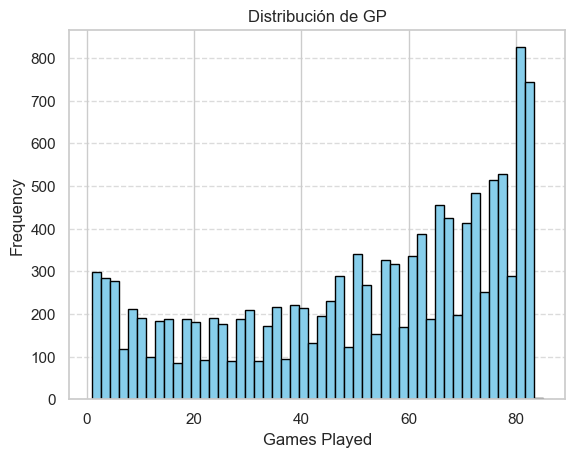

In [63]:
# Distribución partidos jugados

nba_cleanest['gp'].plot.hist(bins=50,edgecolor = 'black', color= 'skyblue')

plt.title('Distribución de GP')
plt.xlabel('Games Played')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha = 0.7)

plt.show

In [64]:
# Estadísticas jugadores que juegan poco

few_matches = nba_cleanest[nba_cleanest['gp'] < 41]

few_matches_clean = few_matches[['gp','draft_round','pts','ast','reb']]

few_matches_clean.describe()

gp          pts          ast          reb
count  4137.000000  4137.000000  4137.000000  4137.000000
mean     19.338893     4.097583     0.948538     2.061591
std      12.111535     3.841375     1.164941     1.721313
min       1.000000     0.000000     0.000000     0.000000
25%       8.000000     1.700000     0.300000     1.000000
50%      19.000000     3.000000     0.600000     1.600000
75%      30.000000     5.100000     1.200000     2.700000
max      40.000000    27.400000    11.100000    16.300000

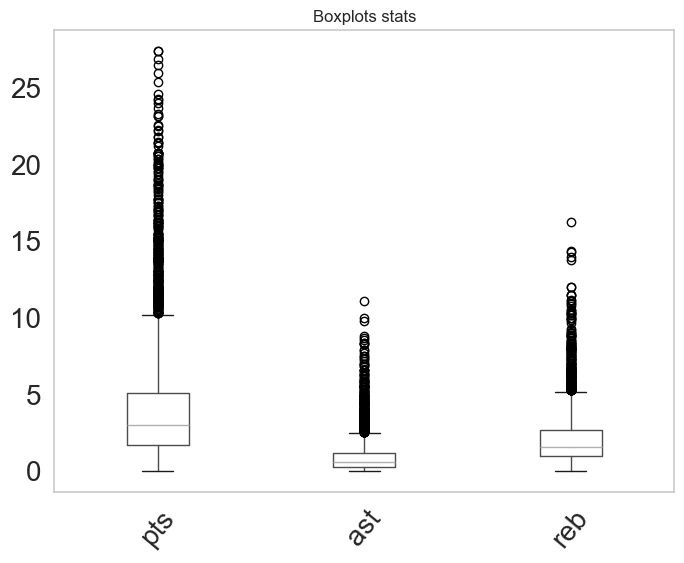

In [65]:
# Grafiquemos este tipo de jugador con Boxplots

boxplot_data = few_matches_clean[['pts','ast','reb']]

plt.figure(figsize=(8, 6))
plt.title('Boxplots stats')
boxplot_data.boxplot(grid=False, rot=50, fontsize=20)
plt.show()

In [66]:
# Outliers de estas distribuciones

few_games_pts = few_matches_clean[few_matches_clean['pts']>10]
few_games_ast = few_matches_clean[few_matches_clean['ast']>2.5]
few_games_reb = few_matches_clean[few_matches_clean['reb']>5]

print(len(few_games_pts['pts']))
print(len(few_games_ast['ast']))
print(len(few_games_reb['reb']))

312
335
231


In [67]:
# Jugadores con más de 41 partidos jugados
condition_1 = nba_cleanest['gp'] > 41

# Jugadores con menos de 41 partidos jugados pero con más de 10 puntos, 2.5 asistencias o 5 rebotes promediados
condition_2 = (nba_cleanest['gp'] <= 41) & ((nba_cleanest['pts'] > 10) | (nba_cleanest['ast'] > 2.5) | (nba_cleanest['reb'] > 5))

# Combinación de ambas
nba_selected_players = nba_cleanest[condition_1 | condition_2]

# Tambien eliminaremos los jugadores que hayan jugado menos del 25% de los partidos (no contamos temporadas de lock-out en los años seleccionados)
nba_selected_players = nba_selected_players[nba_selected_players['gp'] >= 20]

len(nba_selected_players)

9002

In [68]:
# He decidio aumentar la muestra de datos para esta última entrega
len(nba_selected_players)
nba_recent = nba_selected_players[
    (nba_selected_players['season'] == 9)  |
    (nba_selected_players['season'] == 10) |
    (nba_selected_players['season'] == 11) |
    (nba_selected_players['season'] == 12) |
    (nba_selected_players['season'] == 13) |
    (nba_selected_players['season'] == 14) |
    (nba_selected_players['season'] == 15) |
    (nba_selected_players['season'] == 16) |
    (nba_selected_players['season'] == 17) |
    (nba_selected_players['season'] == 18) |
    (nba_selected_players['season'] == 19) |
    (nba_selected_players['season'] == 20) |
    (nba_selected_players['season'] == 21) |
    (nba_selected_players['season'] == 22) |
    (nba_selected_players['season'] == 23)
]

print(len(nba_recent))

5190


In [69]:
nba_recent.head()

age  player_height  player_weight draft_round draft_number  gp   pts  \
5340  28.0         200.66     108.862080           1           10  79  21.4   
5341  20.0         190.50      90.718400           1           11  53   4.3   
5342  24.0         210.82     105.233344           1            9  80   6.7   
5343  22.0         203.20     104.326160           1            8  59   4.7   
5345  33.0         208.28     102.058200           1            1  57   6.6   

      reb  ast  net_rating  oreb_pct  dreb_pct  usg_pct  ts_pct  ast_pct  \
5340  4.4  5.8         2.6     0.024     0.107    0.265   0.534    0.256   
5341  1.1  1.5        -1.4     0.015     0.092    0.205   0.487    0.202   
5342  7.6  1.3         2.5     0.149     0.216    0.124   0.594    0.078   
5343  1.9  0.7        -3.1     0.068     0.125    0.201   0.494    0.094   
5345  4.6  0.7        -2.1     0.089     0.181    0.164   0.507    0.063   

      season  
5340       9  
5341       9  
5342       9  
5343       9  
5345       9

El primer filtro que aplicaremos es entre los jugadores que han jugado menos de la mitad de los partidos de la temporada regular. A partir de ahí, he detectado que seguimos dejando fuera a jugadores con cierto nivel en la liga, y con estadísticas suficientemente importantes como para tenerlos en cuenta y, por último, sí que he decidido dejar fuera a todos aquellos jugadores que, independientemente de sus promedios, no hayan llegado a jugar el 25% de los partidos de la temporada regular, ya que considero que entre estos, la mayoría será información que no nos interesa.

Por otro lado, he considerado acotar el marco temporal en el que se centrará nuestro estudio de 2009 a la actualidad. 

Merece la pena mencionar que en todas las temporadas que analizaremos se jugaron los 81 partidos de temporada regular, es decir, en ninguna de ellas hubo un lockout o reducción de los partidos de la temporada como si sucedió al inicio de la primera década de los 2010.

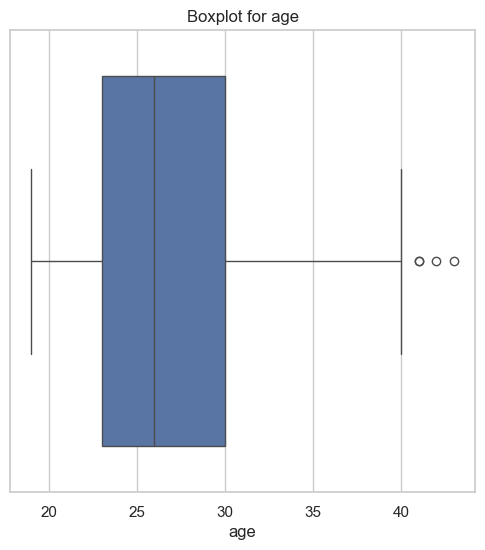

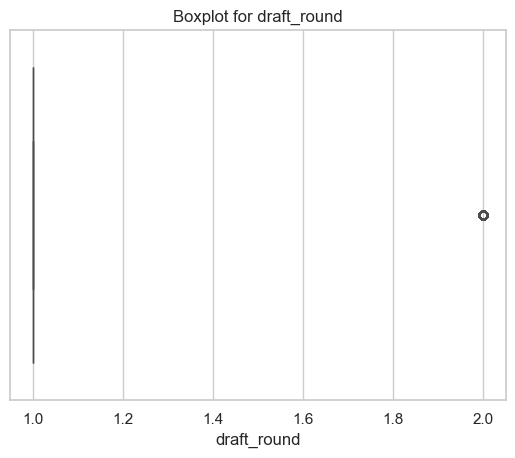

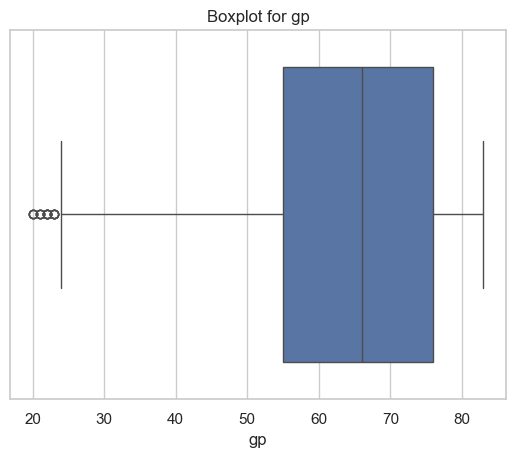

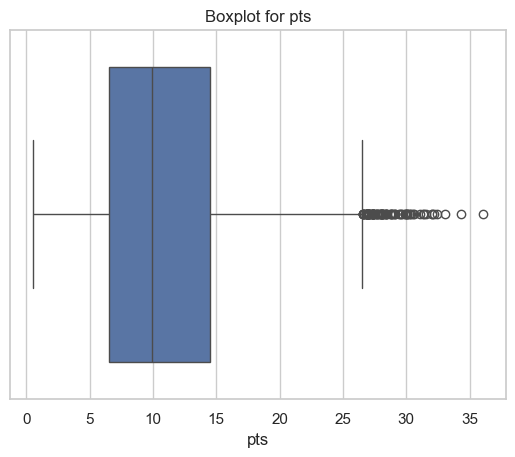

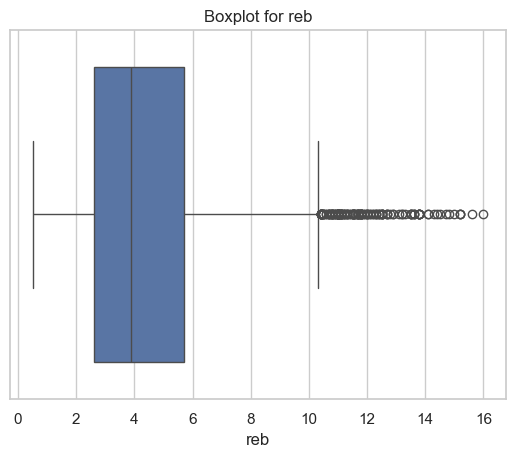

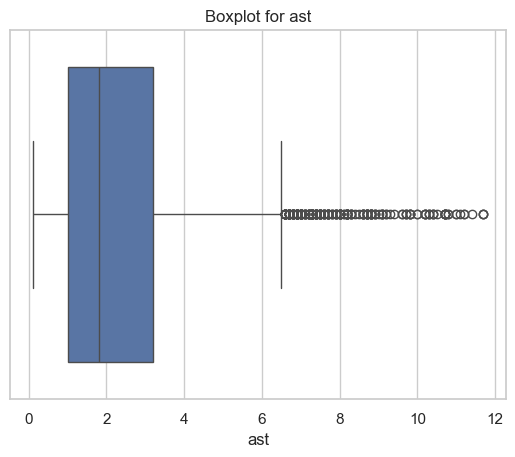

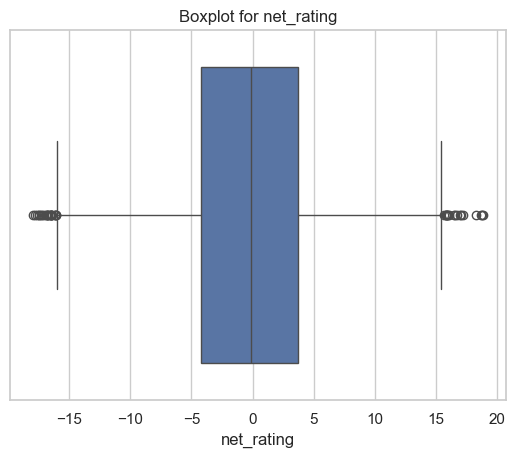

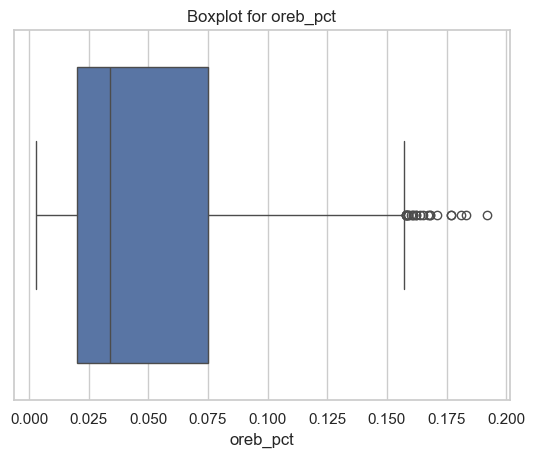

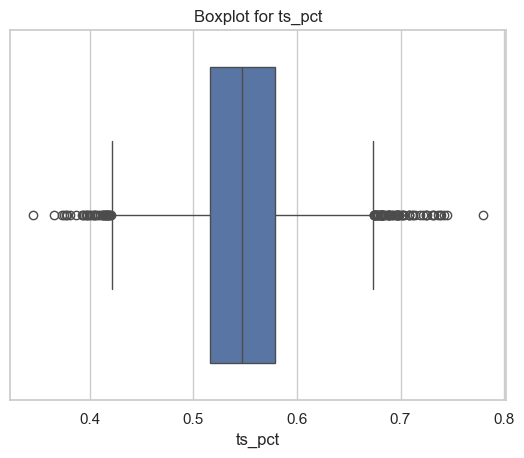

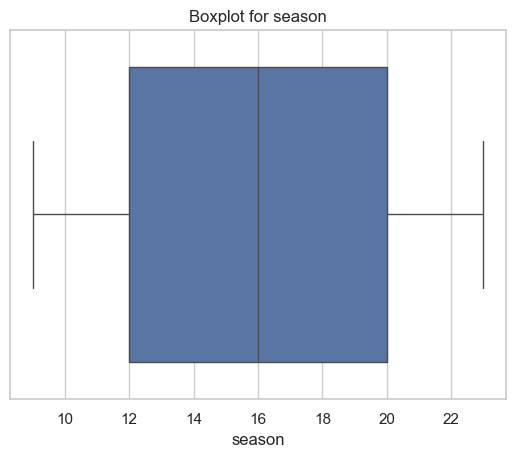

In [167]:
nba_boxplot = nba_recent

plt.figure(figsize=(6, 6))

# Loop through each column in the DataFrame
for column in nba_boxplot.columns:
    # Convert the column values to numeric (ignore errors)
    numeric_values = pd.to_numeric(nba_boxplot[column], errors='coerce')
    
    # Create a boxplot for the current variable
    sns.boxplot(x=numeric_values)
    
    # Set title and labels
    plt.title(f'Boxplot for {column}')
    plt.xlabel(column)
    
    # Show the plot
    plt.show()

Viendo los boxplots, creemos que hay algunos outliers en algunas variables que se pueden tratar. No se analizarán todas las variables porque por el conocimiento adquirido en las anteriores entregas, se sabe o intuye que no todas serán útiles.

**Outliers de la variable Net Rating:**

In [168]:
nba_recent['net_rating'].describe()

count    4534.000000
mean       -0.225320
std         5.916485
min       -18.000000
25%        -4.200000
50%        -0.100000
75%         3.700000
max        18.900000
Name: net_rating, dtype: float64

In [169]:
column = 'net_rating'

third_quartile = np.percentile(nba_boxplot[column].dropna(), 75)
first_quartile = np.percentile(nba_boxplot[column].dropna(), 25)
iqr = third_quartile - first_quartile

upper_limit = third_quartile + 1.5 * iqr
lower_limit = first_quartile - 1.5 * iqr

print(f'El tercer cuartil más 1,5 veces el IQR de {column} es: {upper_limit}')
print(f'El primer cuartil menos 1,5 veces el IQR de {column} es: {lower_limit}')

El tercer cuartil más 1,5 veces el IQR de net_rating es: 15.55
El primer cuartil menos 1,5 veces el IQR de net_rating es: -16.05


In [170]:
# Outliers en Net_Rating - Upper
net_rating_up = nba_recent[nba_recent['net_rating'] > upper_limit]

net_rating_up_clean = net_rating_up[['gp','draft_round','pts','ast','reb','age']]

net_rating_up_clean.describe()

gp        pts        ast        reb        age
count  18.000000  18.000000  18.000000  18.000000  18.000000
mean   66.611111  15.094444   4.000000   5.605556  28.500000
std    15.556874   8.091279   2.556422   3.048524   3.451342
min    34.000000   2.600000   0.200000   1.300000  22.000000
25%    54.500000   7.425000   1.950000   3.425000  26.250000
50%    73.500000  14.150000   4.050000   4.400000  28.000000
75%    79.000000  22.000000   6.450000   8.050000  29.750000
max    81.000000  30.100000   7.700000  13.500000  35.000000

In [171]:
net_rating_up_clean[net_rating_up_clean['gp'] < 41]

gp draft_round   pts  ast  reb   age
7035  34           2  12.9  4.4  3.4  34.0

In [172]:
# Outliers en Net_Rating - Lower
net_rating_low = nba_recent[nba_recent['net_rating'] < lower_limit]

net_rating_low_clean = net_rating_low[['gp','pts','ast','reb','age']]

net_rating_low_clean.describe()

gp        pts        ast        reb        age
count  23.000000  23.000000  23.000000  23.000000  23.000000
mean   50.956522   6.434783   1.069565   3.613043  23.826087
std    12.118649   3.938229   0.864152   1.715254   3.857132
min    29.000000   0.700000   0.100000   0.600000  19.000000
25%    45.000000   4.200000   0.500000   2.550000  20.500000
50%    51.000000   5.200000   0.800000   3.300000  24.000000
75%    55.500000   7.500000   1.350000   4.800000  25.000000
max    81.000000  17.500000   3.500000   7.000000  33.000000

In [173]:
net_rating_low_clean[net_rating_low_clean['gp'] < 41]


gp   pts  ast  reb   age
8280   29  14.8  1.6  4.4  29.0
8330   32   6.7  0.9  5.1  24.0
10941  34   5.5  2.9  2.3  22.0

In [ ]:
# Jugadores con net rating muy neagtivo 
condition_1 = nba_recent['net_rating'] < lower_limit
condition_2 = nba_recent['net_rating'] > upper_limit
condition_3 = nba_recent['gp'] < 41

# Combinación de ambas
unselected = condition_1 & condition_3 | condition_2 & condition_3

nba_recent = nba_recent[~unselected]
len(nba_recent)


Después de analizar los datos de net_rating me he dado cuenta de que tenía que ser bastante restrictivo porque los net_ratings de jugadores que han jugado muchos partidos pueden darnos bastante información. Normalmente, un net_rating muy negativo implica que el jugador ayuda poco al equipo, pero, además, nos da información sobre la situación y calidad del equipo en el que juega.

**Outliers de la variable True Shooting Percentage:**

In [174]:
nba_recent['ts_pct'].describe()

count    4534.000000
mean        0.548306
std         0.050954
min         0.345000
25%         0.516000
50%         0.547000
75%         0.579000
max         0.780000
Name: ts_pct, dtype: float64

In [175]:
column = 'ts_pct'

third_quartile = np.percentile(nba_boxplot[column].dropna(), 75)
first_quartile = np.percentile(nba_boxplot[column].dropna(), 25)
iqr = third_quartile - first_quartile

upper_limit = third_quartile + 1.5 * iqr
lower_limit = first_quartile - 1.5 * iqr

print(f'El tercer cuartil más 1,5 veces el IQR de {column} es: {upper_limit}')
print(f'El primer cuartil menos 1,5 veces el IQR de {column} es: {lower_limit}')

El tercer cuartil más 1,5 veces el IQR de ts_pct es: 0.6734999999999999
El primer cuartil menos 1,5 veces el IQR de ts_pct es: 0.4215000000000001


In [176]:
# Outliers en True Shooting - Upper
ts_up = nba_recent[nba_recent['ts_pct'] > upper_limit]

ts_up_clean = ts_up[['gp','draft_round','pts','ast','reb','age','ts_pct']]

ts_up_clean.describe()

gp        pts        ast        reb        age     ts_pct
count  70.000000  70.000000  70.000000  70.000000  70.000000  70.000000
mean   61.200000   9.432857   1.307143   6.555714  26.614286   0.697986
std    11.749314   4.915422   1.407261   3.352682   3.890877   0.022201
min    35.000000   2.300000   0.100000   1.500000  20.000000   0.674000
25%    52.500000   7.025000   0.600000   4.225000  24.000000   0.681000
50%    61.000000   8.900000   1.050000   5.700000  26.500000   0.691500
75%    71.000000  10.575000   1.475000   8.550000  29.000000   0.708000
max    82.000000  29.100000   9.800000  14.700000  34.000000   0.780000

In [177]:
ts_up_clean[ts_up_clean['gp'] < 41]

gp draft_round  pts  ast  reb   age  ts_pct
10911  40           2  9.4  1.5  5.7  28.0   0.677
12339  35           1  8.0  1.4  8.3  25.0   0.742
12510  39           2  5.1  0.9  5.2  34.0   0.731

In [178]:
# Outliers en True Shooting - Lower
ts_low = nba_recent[nba_recent['ts_pct'] < lower_limit]

ts_low_clean = ts_low[['gp','draft_round','pts','ast','reb','age','ts_pct']]

ts_low_clean.describe()

gp        pts        ast        reb        age     ts_pct
count  39.000000  39.000000  39.000000  39.000000  39.000000  39.000000
mean   49.410256   3.410256   1.553846   2.176923  26.179487   0.401436
std    12.778926   1.729130   1.244957   1.508653   4.838833   0.017586
min    23.000000   0.700000   0.200000   0.800000  19.000000   0.345000
25%    42.500000   2.450000   0.500000   1.200000  22.000000   0.394500
50%    49.000000   2.900000   1.100000   1.800000  25.000000   0.405000
75%    55.000000   4.050000   2.600000   2.400000  30.500000   0.415500
max    79.000000   8.500000   4.300000   8.800000  35.000000   0.421000

In [179]:
ts_low_clean[ts_low_clean['gp'] < 41]

gp draft_round  pts  ast  reb   age  ts_pct
5446   32           1  6.6  3.1  2.4  28.0   0.410
5530   23           1  3.8  3.3  1.2  32.0   0.377
6992   26           2  8.5  1.1  5.8  25.0   0.415
8305   34           2  4.3  3.1  1.4  22.0   0.394
8667   29           1  4.3  3.8  8.8  31.0   0.406
10941  34           1  5.5  2.9  2.3  22.0   0.399
12575  37           1  5.0  2.6  2.2  20.0   0.393

La realidad es que después de analizar los datos de ts_pct, no veo la razón por la que deberíamos eliminar las observaciones que me parecían más sospechosas. Todos los jugadores con un ts_pct alto parecen ser jugadores interiores con una dificultad de tiro baja y creo que al eliminarlos, tanto a ellos como a los del ts_pct bajo (que son principalmente bases con un tiro poco fiable) estaríamos eliminando jugadores de un tipo muy concreto que puede enriquecer al modelo.

# Exploracion de los datos restantes

<Axes: >

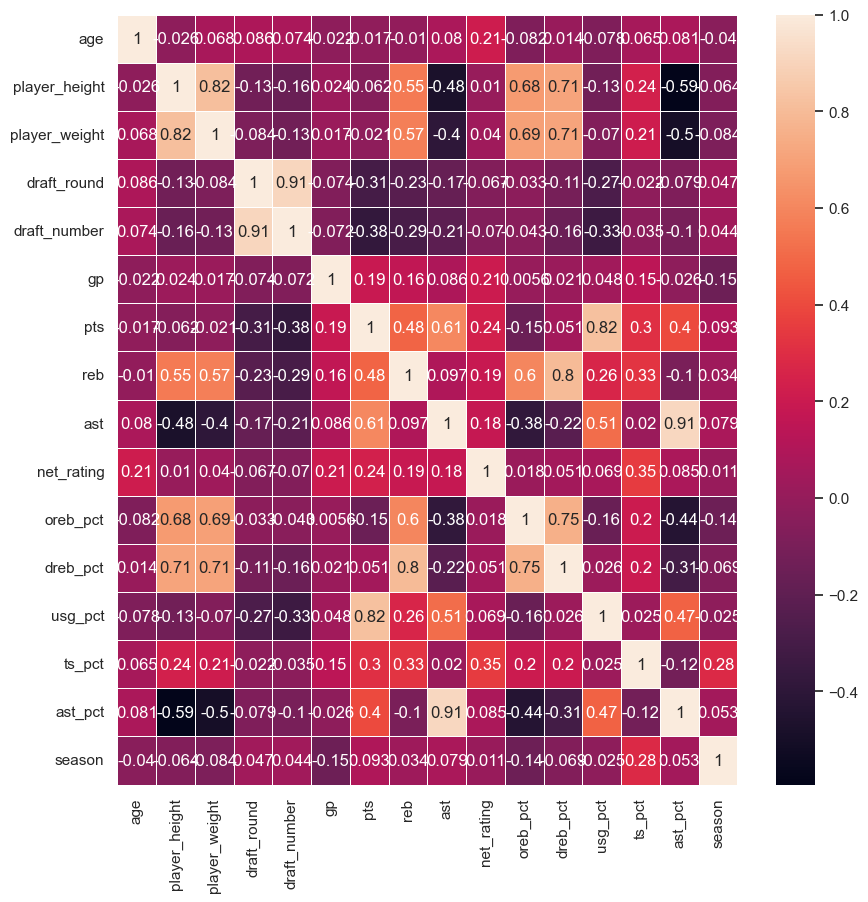

In [70]:
# Graficamos la matriz de correlación de las variables que nos quedamos hasta ahora

plt.figure(figsize=(10, 10))
sns.heatmap(nba_recent.corr(), annot = True, linewidths=0.5)

Con esta información, nos damos cuenta de que hay variables muy correlacionadas que pueden amplificar su información indebidamente y que creo oportuno eliminar antes de seguir con el análisis. El 'thereshold' usado es 0,75 de correlación.

- El peso y la altura, son dos variables que nos aportan prácticamente lo mismo, así que una de las dos debería ser eliminada. Inicialmente, tenía pensado solo eliminar una, pero viendo que ambas variables están altamente relacionadas con diversas más, he decidió eliminar las dos. Para este estudio prefiero céntrame en variables relacionadas con el juego.
- Asistencias y As_pct, también lo están por encima del 75% y, tiene sentido, miden cosas muy similares. En este caso, vamos a eliminar el ast_pct para analizar el valor total de asistencias y no la estadística avanzada. También está más relacionada con peso y altura, así que me parece lo correcto.
- También vemos que los puntos están altamente relacionados con el usg_pct, cosa que tiene sentido debido al tipo de juego, especialmente de los bases de la liga, de los últimos años. Eliminaremos el usg_pct, ya que valoro los puntos como una estadística más importante.
- Otras variables que están relacionadas con los rebotes con los dreb_pct. Aquí sucede lo mismo, valoro quedarme con los rebotes totales, ya que nos dan más información global y eliminaré la variable dreb_pct.
- Draft_round y draft_number también lo están en exceso, así que vamos a eliminar una de las dos, en este caso 'draft_number'. Pero lo haremos más adelante porque nos ayudará en los siguientes pasos.

In [71]:
variables_correlacionadas = nba_recent[['player_weight','player_height','ast_pct','usg_pct','dreb_pct']]
nba_recent = nba_recent.drop(columns = variables_correlacionadas)
nba_recent.head()

age draft_round draft_number  gp   pts  reb  ast  net_rating  oreb_pct  \
5340  28.0           1           10  79  21.4  4.4  5.8         2.6     0.024   
5341  20.0           1           11  53   4.3  1.1  1.5        -1.4     0.015   
5342  24.0           1            9  80   6.7  7.6  1.3         2.5     0.149   
5343  22.0           1            8  59   4.7  1.9  0.7        -3.1     0.068   
5345  33.0           1            1  57   6.6  4.6  0.7        -2.1     0.089   

      ts_pct  season  
5340   0.534       9  
5341   0.487       9  
5342   0.594       9  
5343   0.494       9  
5345   0.507       9

<Axes: >

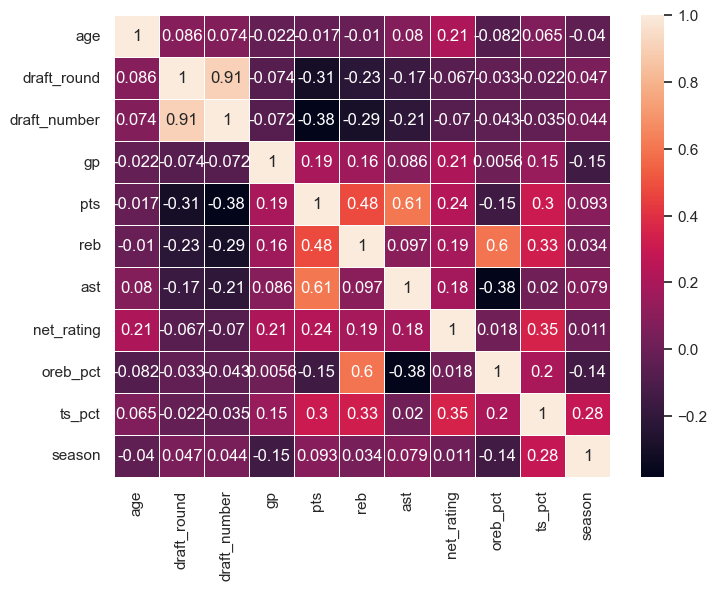

In [72]:
# Graficamos la matriz de correlación de las variables restantes
plt.figure(figsize=(8, 6))
sns.heatmap(nba_recent.corr(), annot = True, linewidths=0.5)

In [73]:
# Repaso concreto de las correalciones con la variable objetivo
correlations = nba_recent.corr()
corr_draftround = correlations['draft_round']
corr_draftround

age             0.086132
draft_round     1.000000
draft_number    0.907795
gp             -0.073858
pts            -0.305997
reb            -0.228471
ast            -0.170484
net_rating     -0.067234
oreb_pct       -0.032727
ts_pct         -0.022336
season          0.047303
Name: draft_round, dtype: float64

<Figure size 2000x1000 with 0 Axes>

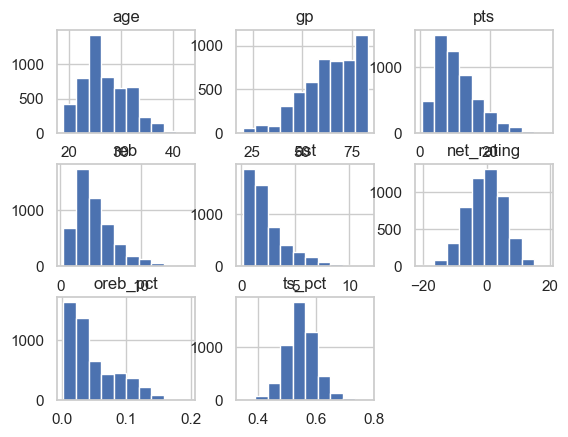

In [74]:
season = ['season']
nba_hist = nba_recent.drop(columns=season)

plt.figure(figsize = (20,10))
nba_hist.hist()
plt.show()

# Clasificación Binaria

Las variables que podríamos usar para la clasificación binaria son varias, pero todas ellas necesitan modificaciones previas, ya que ninguna de las que vienen en el dataset inicialmente se pueden usar sin ellas.

Para nuestro modelo, usaremos la variable 'draft_round', que en caso de que eliminemos a todos los jugadores undrafted (cada vez son menos porque eran la mayoría de los jugadores con muy pocos partidos) podemos tener una variable binaria entre jugadores de primera y segunda ronda.

Veámoslo con este gráfico, por un lado, graficamos los jugadores que usaremos 'Kept_Players' que son los jugadores que han pasado los filtros aplicados anteriormente a nuestro dataset. Por otro, los jugadores que hemos eliminado por falta de partidos jugados.

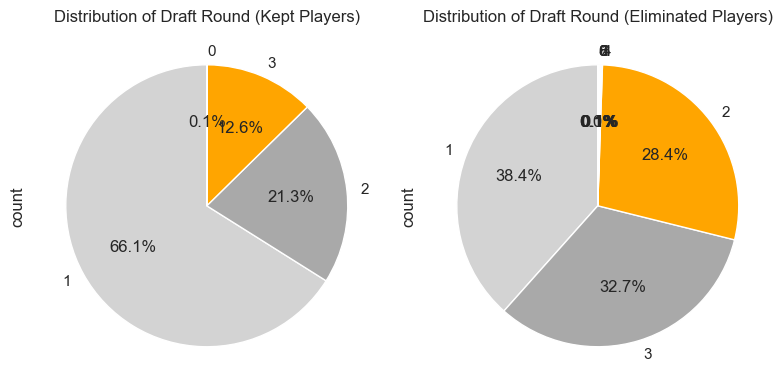

In [75]:
colors = ['lightgray' if round_num != 2 and round_num != 3 else 'darkgray' 
               if round_num == 2 else 'orange' for round_num in range(1, 8)]

fig, axes = plt.subplots(1, 2, figsize=(8, 4))

# Jugadores con los que trabajaremos
nba_recent['draft_round'].value_counts().plot.pie(autopct='%1.1f%%', startangle=90, ax=axes[0], 
                                                  colors=colors)

axes[0].set_title('Distribution of Draft Round (Kept Players)')

# Jugadores con pocos partidos 
few_matches_clean['draft_round'].value_counts().plot.pie(autopct='%1.1f%%',startangle=90, ax=axes[1], 
                                                         colors=colors)

axes[1].set_title('Distribution of Draft Round (Eliminated Players)')

plt.tight_layout()
plt.show()


Se ve claramente que los jugadores de la ronda 3, es decir los undrafted, cada vez tienen menos importancia en nuestra distribución, así que los vamos a eliminar.

Por otro lado, también se observa que hay algunos errores en los datos que nos quedan, ya que un porcentaje pequeño de jugadores parece que son de la ronda 0, cosa que no existe y que se debe examinar.

In [76]:
# Comprovamos el error en los datos (tenemos jugadores que han sido elegidos en la ronda 0 del draft)
nba_data_zero = nba_recent[nba_recent['draft_round'] == '0']
nba_data_zero

age draft_round draft_number  gp  pts  reb  ast  net_rating  oreb_pct  \
10966  28.0           0           61  71  6.5  2.7  5.0         1.1     0.028   
11498  29.0           0           61  69  8.6  3.7  6.6         2.5     0.030   
12247  30.0           0           61  27  8.5  3.3  4.9        -5.5     0.029   

       ts_pct  season  
10966   0.540      20  
11498   0.583      21  
12247   0.525      22

Vemos que hay tres observaciones con una ronda del draft igual a cero, la cual cosa no tiene sentido. Parece ser el mismo jugador en distintas temporadas, pero aún así, viendo que su 'draft_number' es de 61, podemos entender que previamente tenía un valor de 'undrafted' en esta variable, la cual cosa nos ayuda, ya que para el estudio que estamos haciendo, hemos eliminado a todos los undrafteds y haremos lo mismo con este.

En el otro gráfico, vemos que sucede lo mismo, pero es menos importante, ya que son datos que ya no usaremos y que solo he añadido a modo de justificar la decisión que estábamos tomando.

In [77]:
# Eliminamos estas tres observaciones
nba_recent = nba_recent[(nba_recent['draft_round'] != '0')]

# Eliminamos los jugadores con 'draft_round' = 3
nba_recent = nba_recent[(nba_recent['draft_round'] != 3)]

In [78]:
# Faltaria eliminar la variable draft_number porque, como hemos visto, nos da demasiada información de draft_round
draft_number = nba_recent[['draft_number']]
nba_recent = nba_recent.drop(columns = draft_number)

In [79]:
nba_recent.head()

age draft_round  gp   pts  reb  ast  net_rating  oreb_pct  ts_pct  \
5340  28.0           1  79  21.4  4.4  5.8         2.6     0.024   0.534   
5341  20.0           1  53   4.3  1.1  1.5        -1.4     0.015   0.487   
5342  24.0           1  80   6.7  7.6  1.3         2.5     0.149   0.594   
5343  22.0           1  59   4.7  1.9  0.7        -3.1     0.068   0.494   
5345  33.0           1  57   6.6  4.6  0.7        -2.1     0.089   0.507   

      season  
5340       9  
5341       9  
5342       9  
5343       9  
5345       9

In [80]:
print(len(nba_recent))

4534


C:\Users\Marc\AppData\Local\Temp\ipykernel_3868\3926588198.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='draft_round', y=feature, data=nba_recent, ax=axes[i], palette='husl')
C:\Users\Marc\AppData\Local\Temp\ipykernel_3868\3926588198.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='draft_round', y=feature, data=nba_recent, ax=axes[i], palette='husl')
C:\Users\Marc\AppData\Local\Temp\ipykernel_3868\3926588198.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='draft_round', y=feature, data=nba_recent, ax=axes[i], pa

C:\Users\Marc\AppData\Local\Temp\ipykernel_3868\3926588198.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='draft_round', y=feature, data=nba_recent, ax=axes[i], palette='husl')


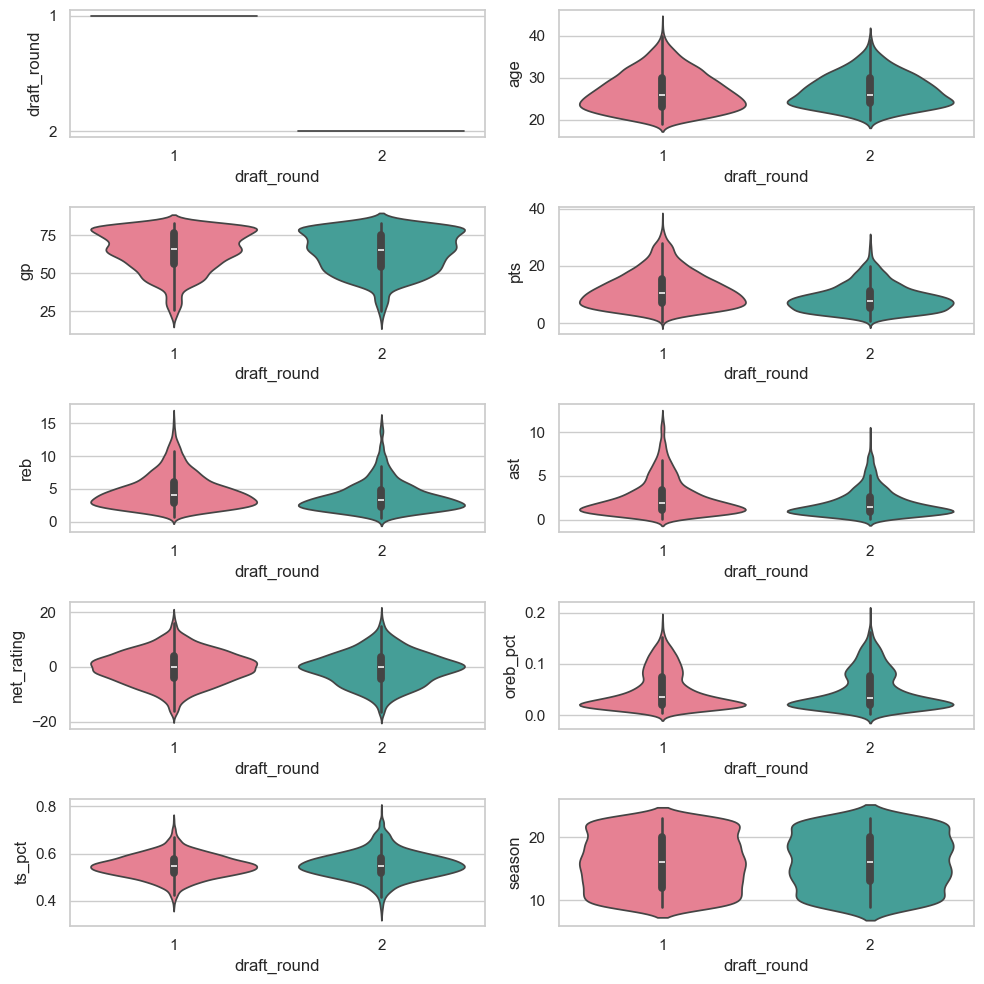

In [81]:
sns.set(style="whitegrid")

selected_features = ['draft_round','age', 'gp', 'pts','reb','ast','net_rating','oreb_pct','ts_pct','season']

fig, axes = plt.subplots(nrows=len(selected_features) // 2, ncols=2, figsize=(10, 2 * (len(selected_features) // 2)))
axes = axes.flatten()

for i, feature in enumerate(selected_features):
    sns.violinplot(x='draft_round', y=feature, data=nba_recent, ax=axes[i], palette='husl')

plt.tight_layout()
plt.show()

<Figure size 1500x1500 with 0 Axes>

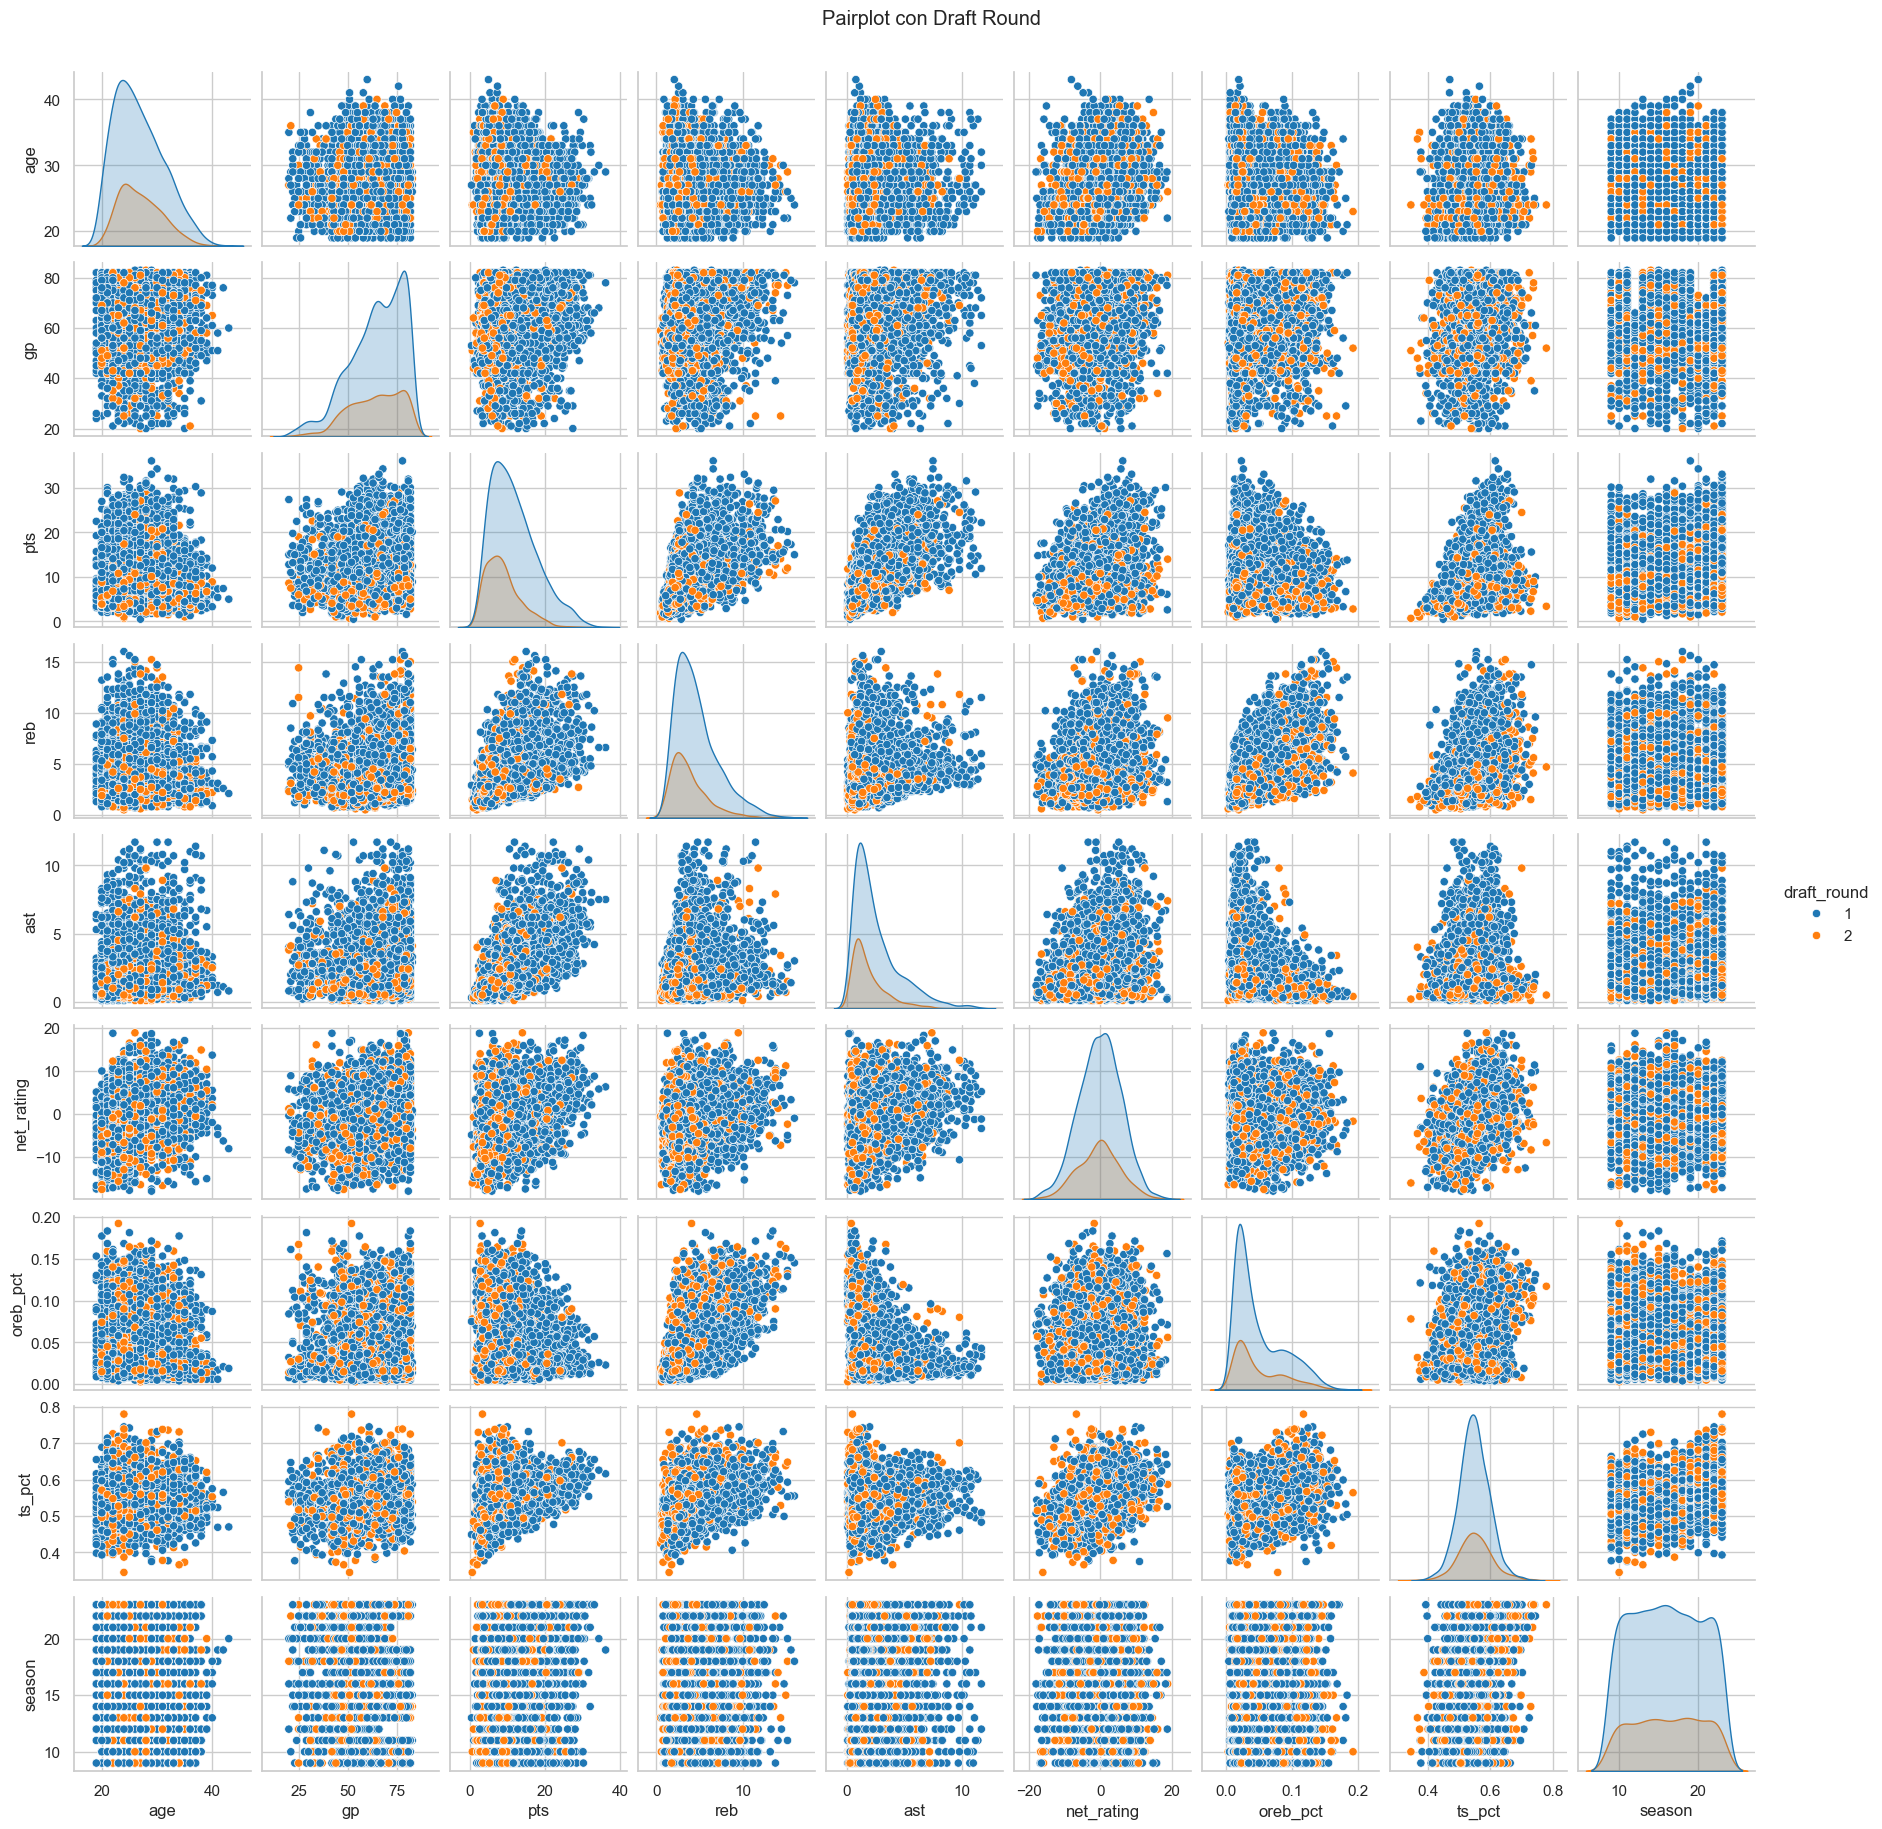

In [82]:
pairplot_data = nba_recent

plt.figure(figsize=(15, 15)) 
sns.pairplot(pairplot_data, height=2, palette='tab10', hue='draft_round')
plt.suptitle('Pairplot con Draft Round', y=1.02) 
plt.show()

Con estos dos últimos gráficos, tenemos una idea un poco más clara de las diferencias (o no) que hay entre los 'grupos' de jugadores de primera y segunda ronda.

Sobre todo el primero gráfico, que normalmente nos ayuda cuando hacemos tests ANOVA, visualiza las distribuciones de cada grupo de forma separada, y sirve para ver si los principales rasgos de la distribución son similares o no entre los grupos. Podemos ver que en pocos grupos hay diferencias remarcables.

En el segundo también intentamos ver la separabilidad de los grupos visualizando los datos en dos dimensiones, observando que, en prácticamente todos los casos, parecen estar bastante mezclados y siguen tendencias difíciles de predecir. También en los gráficos de densidad se ve que la separabilidad entre grupos será complicada.

# Regresión Logística - Sin Parametrizar

Hasta aquí hemos hecho las transformaciones necesarias para aplicar la clasificación logística. Necesitábamos una variable binaria, y en el proceso, hemos tenido que organizar nuestro data set y hacer distintas correcciones alrededor de esta para poder obtener un formato de datos que nos permitan aplicar correctamente la Regresión Logística.

Ahora, antes de crear el modelo intentaremos balancear los datos y mejorar la selección de variables, realizando un previo análisis de información mutua y de componenetes.

Al finalizar, crearemos el modelo parametrizandolo con los tres métodos vistos en clase, el Grid Search, el Random Search y el Método Bayesiano.

**Balanceamos las clases de la variable objetivo**

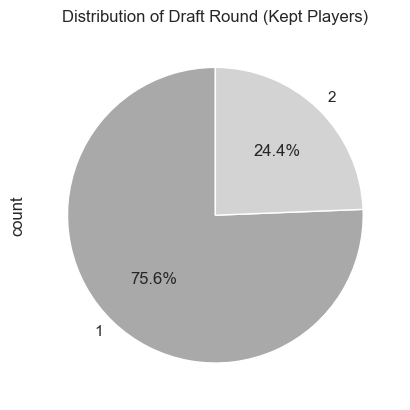

In [83]:
# Ver visualmente datos desbalanceados
colors = ['lightgray' if round_num != 1 else 'darkgray' for round_num in range(1, 8)]

nba_recent['draft_round'].value_counts().plot.pie(autopct='%1.1f%%', startangle=90, colors=colors)

plt.title('Distribution of Draft Round (Kept Players)')
plt.show()


In [84]:
round1 = nba_recent[nba_recent['draft_round'] == '1']
round2 = nba_recent[nba_recent['draft_round'] == '2']

print(len(round1))
print(len(round2))

3429
1105


In [85]:
# Balanceamos los datos
draft_1 = '1'
draft_2 = '2'
reduced_1 = 0.67
reduced_2 = 0.01

indices1 = nba_recent[nba_recent['draft_round'] == draft_1].index
indices2 = nba_recent[nba_recent['draft_round'] == draft_2].index

np.random.seed(33)

reduced1 = np.random.choice(indices1, size=int(len(indices1) * reduced_1), replace=False)
reduced2 = np.random.choice(indices2, size=int(len(indices2) * reduced_2), replace=False)

balanced_nba_recent = nba_recent.drop(set(reduced1).union(set(reduced2)))

In [86]:
balanced_nba_recent.head()

age draft_round  gp   pts  reb  ast  net_rating  oreb_pct  ts_pct  \
5340  28.0           1  79  21.4  4.4  5.8         2.6     0.024   0.534   
5341  20.0           1  53   4.3  1.1  1.5        -1.4     0.015   0.487   
5342  24.0           1  80   6.7  7.6  1.3         2.5     0.149   0.594   
5343  22.0           1  59   4.7  1.9  0.7        -3.1     0.068   0.494   
5348  29.0           1  82   5.5  8.7  0.3         9.0     0.131   0.652   

      season  
5340       9  
5341       9  
5342       9  
5343       9  
5348       9

In [87]:
len(balanced_nba_recent['draft_round'])

2226

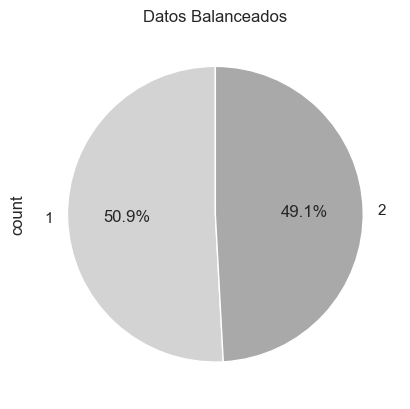

In [88]:
# Datos balanceados
colors = ['lightgray', 'darkgray']
balanced_nba_recent['draft_round'].value_counts().plot.pie(autopct='%1.1f%%', startangle=90, colors=colors)

plt.title('Datos Balanceados')
plt.show()


**PCA**

In [89]:
# PCA
pca = PCA(random_state=79)
x_pca = pca.fit_transform(balanced_nba_recent)

explained_variance_ratio = pd.Series(pca.explained_variance_ratio_)
print(explained_variance_ratio.round(2))

0    0.64
1    0.14
2    0.09
3    0.06
4    0.05
5    0.02
6    0.01
7    0.00
8    0.00
9    0.00
dtype: float64


In [90]:
loadings = pd.DataFrame(pca.components_.T, columns=[f"Componente {i+1}" for i in range(pca.components_.shape[0])]
                        , index=balanced_nba_recent.columns)
print(loadings.round(2))

             Componente 1  Componente 2  Componente 3  Componente 4  \
age                 -0.01          0.22         -0.27          0.26   
draft_round          0.00         -0.01         -0.02         -0.01   
gp                  -0.98         -0.17         -0.00         -0.05   
pts                 -0.11          0.60          0.71          0.22   
reb                 -0.04          0.15          0.14          0.04   
ast                 -0.02          0.13          0.13          0.04   
net_rating          -0.13          0.72         -0.60         -0.14   
oreb_pct            -0.00         -0.00         -0.00          0.00   
ts_pct              -0.00          0.00          0.00         -0.00   
season               0.04          0.12          0.19         -0.93   

             Componente 5  Componente 6  Componente 7  Componente 8  \
age                  0.90          0.03         -0.03         -0.01   
draft_round          0.01         -0.01         -0.01          1.00   
gp   

**Estudio de la Información Mutua**

C:\Users\Marc\AppData\Local\Temp\ipykernel_3868\3964193913.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='attributes', data=ig_df, palette='tab10')


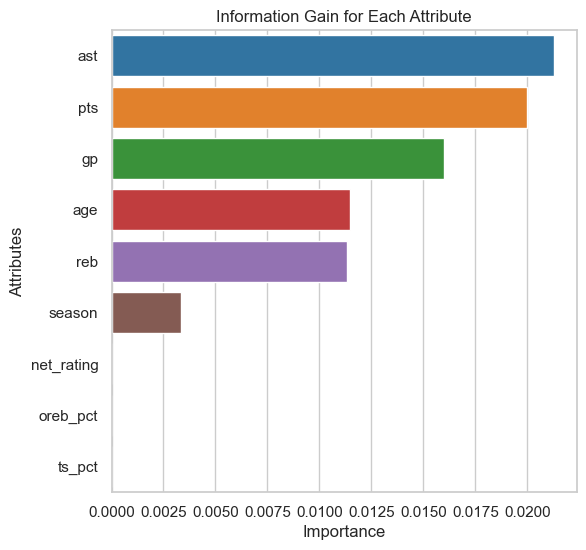

In [91]:
features = balanced_nba_recent.drop(columns=['draft_round'])

# Calculate information gain
info_gain = mutual_info_classif(features, balanced_nba_recent['draft_round'])

# Create a DataFrame for plotting
ig_df = pd.DataFrame({'attributes': features.columns, 'importance': info_gain})
ig_df = ig_df.sort_values(by='importance', ascending=False)

# Plot the information gain
plt.figure(figsize=(6, 6))
sns.barplot(x='importance', y='attributes', data=ig_df, palette='tab10')
plt.title('Information Gain for Each Attribute')
plt.xlabel('Importance')
plt.ylabel('Attributes')
plt.show()

Los resultados son un poco contradictorios, por un lado observamos que con los dos primeros componenetes del PCA podemos obtener el 78% de la varianza de la variable objetivo. El primero componente nos da una varaible que también parace tener incidencia en el estudio de información mutua pero el segundo componente esta descrito principalmente por la variable net_rating que según la información mutua no tiene primpacto sobre la variable objetivo. Visto esto, y conociendo el dominio porque ya lo hemos estudiado a fondo en otroas entregas, he decidido hacer los modelos con todas las variables.

# Regresión Logística - Modelo Sin Parametrizar


Emepzaremos viendo los resultados del modelo sin parametrizar, para hacernos una idea con que referencia deberemos comparar una vez lo vayamos ajustando. 

In [92]:
X = balanced_nba_recent.drop(columns = 'draft_round')
y = balanced_nba_recent['draft_round']

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=33)

start = time.time()
model = LogisticRegression(random_state=33)
model.fit(X_train, y_train)

print('Training Data:', len(X_train))
print('Testing Data:', len(y_test))

Training Data: 1780
Testing Data: 446


Tiempo de ejecución: 0.03764915466308594 segundos
Accuracy: 0.6166

Confusion Matrix:

Classification Report:
              precision    recall  f1-score   support

           1       0.65      0.57      0.61       233
           2       0.59      0.67      0.63       213

    accuracy                           0.62       446
   macro avg       0.62      0.62      0.62       446
weighted avg       0.62      0.62      0.62       446



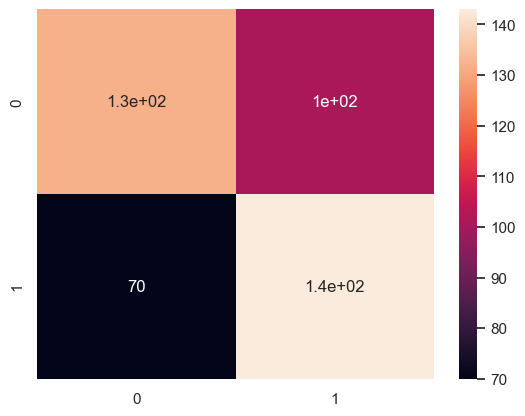

In [93]:
y_pred = model.predict(X_test)

end = time.time()
execution_time = end - start
print(f"Tiempo de ejecución: {execution_time} segundos")

accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print("\nConfusion Matrix:")
sns.heatmap(conf_matrix, annot = True)
print("\nClassification Report:")
print(classification_rep)

La verdad es que no es un gran modelo (ya lo sabíamos) pero veamos si lo podemos optimizar con los distintos métodos vistos en clase y mejorar los resultados de precisión.

También es importante mencionar que el modelo sin parametrizar tiene un tiempo de ejecución muy bajo, cosa que se deberá tener en cuenta en caso de que los resultados sean muy parecidos.

# Regresión Logística - Grid Search


In [180]:
X_2 = balanced_nba_recent.drop(columns=['draft_round'])
y_2 = balanced_nba_recent['draft_round']

scaler = StandardScaler()
X_2 = scaler.fit_transform(X_2)

X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_2, y_2, test_size=0.2, random_state=79)

print('Training Data:', len(X_train_2))
print('Testing Data:', len(y_test_2))

Training Data: 1780
Testing Data: 446


In [181]:
start = time.time()
param_grid = {
    'solver': ['lbfgs', 'liblinear','newton-cg','newton-cholesky'],
    'max_iter': [50, 100, 150, 200, 250, 300, 1000],
    'C':[2, 3, 4, 5, 10]
}

In [96]:
model_grid = LogisticRegression(random_state=33)
model_grid.get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': 33,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [182]:
grid = GridSearchCV(model_grid, param_grid, cv=5, scoring= "accuracy")
grid.fit(X_train_2, y_train_2)

print("Mejores parámetros:", grid.best_params_)
print("Accuracy del mejor modelo", grid.best_score_)

Mejores parámetros: {'C': 2, 'max_iter': 50, 'solver': 'liblinear'}
Accuracy del mejor modelo 0.6123595505617978


Tiempo de ejecución: 18.799569606781006 segundos
Accuracy: 0.6211

Confusion Matrix:



Classification Report:
              precision    recall  f1-score   support

           1       0.63      0.57      0.60       222
           2       0.61      0.67      0.64       224

    accuracy                           0.62       446
   macro avg       0.62      0.62      0.62       446
weighted avg       0.62      0.62      0.62       446



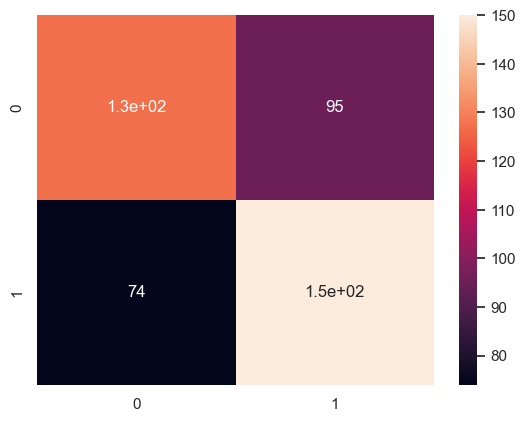

In [183]:
post_model_grid = LogisticRegression(C =  2, max_iter = 50, solver = 'lbfgs', random_state=33)
post_model_grid.fit(X_train_2, y_train_2)

y_pred_grid = post_model_grid.predict(X_test_2)

end = time.time()
execution_time = end - start
print(f"Tiempo de ejecución: {execution_time} segundos")

accuracy2 = accuracy_score(y_test_2, y_pred_grid)
conf_matrix2 = confusion_matrix(y_test_2, y_pred_grid)
classification_rep2 = classification_report(y_test_2, y_pred_grid)

print(f"Accuracy: {accuracy2:.4f}")
print("\nConfusion Matrix:")
sns.heatmap(conf_matrix2, annot = True)
print("\nClassification Report:")
print(classification_rep2)

Hemos empezado intentando mejorar nuestro modelo con el método Grid Search, para ello le hemos introducido una serie de parámetros entre los cuales queríamos determinar la mejor combinación para mejorar los resultados de estos. Resulta sorprendente observar la pequeñísima mejora que obtenemos de los resultados. No son exactamente iguales (como he pensado durante mucho tiempo haciendo esta entrega, tenía que redondear con más decimales para descubrirlo, pero sí muy similares).

Claramente, no es un modelo que nos vaya a servir para mejorar el anterior porque la mejora de precisión es de 0,05 y el tiempo de ejecución es muchísimo más alto, en este caso son 27 segundos. No es eficiente.

# Regresión Logistica - Random Search

In [99]:
X_3 = balanced_nba_recent.drop(columns=['draft_round'])
y_3 = balanced_nba_recent['draft_round']

scaler = StandardScaler()
X_3 = scaler.fit_transform(X_3)

X_train_3, X_test_3, y_train_3, y_test_3 = train_test_split(X_3, y_3, test_size=0.2, random_state=33)

print('Training Data:', len(X_train_3))
print('Testing Data:', len(y_test_3))

Training Data: 1780
Testing Data: 446


In [100]:
start = time.time()
model_random = LogisticRegression(random_state=79)

param_random = {
    'solver': ['lbfgs', 'liblinear','newton-cg','newton-cholesky'],
    'max_iter': [50, 100, 150, 200, 250, 300, 1000],
    'C':[2, 3, 4, 5, 10]
}

In [101]:
random = RandomizedSearchCV(estimator=model_random, param_distributions=param_random, scoring='accuracy', cv=5, random_state=33)

random.fit(X_train_3, y_train_3)

print("Mejores parámetros:", random.best_params_)
print("Accuracy del mejor modelo en el entrenamiento:", random.best_score_)


Mejores parámetros: {'solver': 'newton-cg', 'max_iter': 1000, 'C': 5}
Accuracy del mejor modelo en el entrenamiento: 0.6162921348314606


Tiempo de ejecución: 1.2107441425323486 segundos
Accuracy: 0.6166

Confusion Matrix:

Classification Report:
              precision    recall  f1-score   support

           1       0.65      0.57      0.61       233
           2       0.59      0.67      0.63       213

    accuracy                           0.62       446
   macro avg       0.62      0.62      0.62       446
weighted avg       0.62      0.62      0.62       446



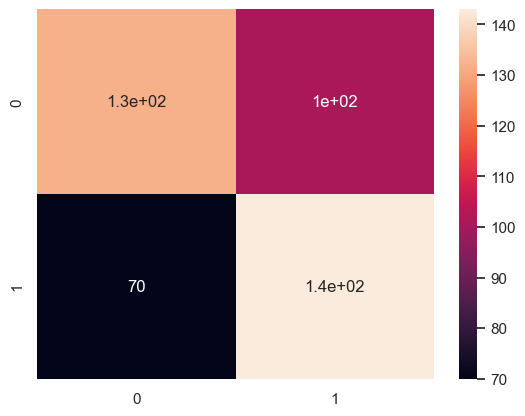

In [102]:
model_random = LogisticRegression(C = 5, max_iter = 1000, solver = 'newton-cg', random_state=33)
model_random.fit(X_train_3, y_train_3)

y_pred_random = model_random.predict(X_test_3)

end = time.time()
execution_time = end - start
print(f"Tiempo de ejecución: {execution_time} segundos")

accuracy3 = accuracy_score(y_test_3, y_pred_random)
conf_matrix3 = confusion_matrix(y_test_3, y_pred_random)
classification_rep3 = classification_report(y_test_3, y_pred_random)

print(f"Accuracy: {accuracy3:.4f}")
print("\nConfusion Matrix:")
sns.heatmap(conf_matrix3, annot = True)
print("\nClassification Report:")
print(classification_rep3)

Este tercer caso da prácticamente los mismos resultados que el primer modelo creado. Pero evidentemente, como estamos usando el método Random Search, tiene que hacer las iteraciones para encontrar el mejor modelo disponible y eso hace que acabe teniendo un tiempo de ejecución más largo, así que no parece que sea un mejor modelo que él sin parametrizar.

**Segundo modelo con Random Search pero menos iteraciones:**

Para indagar un poco más en el Random Search, he querido probar de fijar las iteraciones de este a un número mucho menor del que tenemos arriba e intentar ver si en este caso obtenemos el mínimo global o si obtenemos un modelo claramente peor porque nos quedamos en un mínimo local.

In [106]:
start = time.time()
model_random2 = LogisticRegression(random_state=33)

param_random2 = {
    'solver': ['lbfgs', 'liblinear','newton-cg','newton-cholesky'],
    'C':[2, 3, 4, 5, 10]
    }

In [107]:
random2 = RandomizedSearchCV(estimator=model_random2, param_distributions=param_random2, scoring='accuracy', n_iter = 2, cv=5, random_state=33)

random2.fit(X_train_3, y_train_3)

print("Mejores parámetros:", random2.best_params_)
print("Accuracy del mejor modelo en el entrenamiento:", random2.best_score_)


Mejores parámetros: {'solver': 'liblinear', 'C': 10}
Accuracy del mejor modelo en el entrenamiento: 0.6162921348314606


Tiempo de ejecución: 2.1033518314361572 segundos
Accuracy: 0.6166

Confusion Matrix:

Classification Report:
              precision    recall  f1-score   support

           1       0.65      0.57      0.61       233
           2       0.59      0.67      0.63       213

    accuracy                           0.62       446
   macro avg       0.62      0.62      0.62       446
weighted avg       0.62      0.62      0.62       446



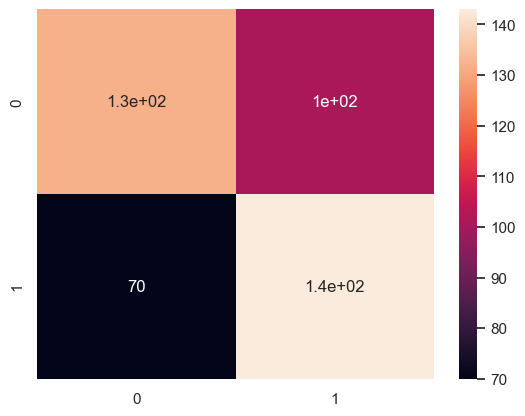

In [108]:
model_random2 = LogisticRegression(C = 10, solver = 'liblinear', random_state=33)
model_random2.fit(X_train_3, y_train_3)

y_pred_random2 = model_random2.predict(X_test_3)

end = time.time()
execution_time = end - start
print(f"Tiempo de ejecución: {execution_time} segundos")

accuracy4 = accuracy_score(y_test_3, y_pred_random2)
conf_matrix4 = confusion_matrix(y_test_3, y_pred_random2)
classification_rep4 = classification_report(y_test_3, y_pred_random2)

print(f"Accuracy: {accuracy4:.4f}")
print("\nConfusion Matrix:")
sns.heatmap(conf_matrix4, annot = True)
print("\nClassification Report:")
print(classification_rep4)

La verdad es que estos resultados me parecen sorprendentes. El modelo vuelve a darnos una precisión exactamente igual a la del modelo sin parametrizar y al modelo anterior que hacía 1000 iteraciones, en este caso hemos fijado las iteraciones y son 2.

Si bien es cierto que al hacer tan pocas iteraciones el tiempo de ejecución del modelo es muy reducido, aún un poco mayor al del modelo sin parametrizar, pero la diferencia es mínima.

# Regresión Logística - Método Bayesiano

In [109]:
X_4 = balanced_nba_recent.drop(columns=['draft_round'])
y_4 = balanced_nba_recent['draft_round']

scaler = StandardScaler()
X_4 = scaler.fit_transform(X_4)

X_train_4, X_test_4, y_train_4, y_test_4 = train_test_split(X_4, y_4, test_size=0.2, random_state=33)

print('Training Data:', len(X_train_4))
print('Testing Data:', len(y_test_4))

Training Data: 1780
Testing Data: 446


In [110]:
start_time = time.time()
param_bayes = {
    'solver': ['lbfgs', 'liblinear','newton-cg','newton-cholesky'],
    'max_iter': [50, 100, 150, 200, 250, 300, 1000],
    'C':[2, 3, 4, 5, 10]
}

bayes = LogisticRegression(random_state=33)

bayes_search = BayesSearchCV(bayes, search_spaces = param_bayes, scoring="accuracy", cv=5, n_jobs=-1)
np.int = int
bayes_search.fit(X_train_4, y_train_4)

print("Mejores parámetros:", bayes_search.best_params_)
print("Accuracy del mejor modelo en el entrenamiento:", bayes_search.best_score_)

c:\Users\Marc\AppData\Local\Programs\Python\Python312\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\Marc\AppData\Local\Programs\Python\Python312\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\Marc\AppData\Local\Programs\Python\Python312\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Mejores parámetros: OrderedDict({'C': 4, 'max_iter': 250, 'solver': 'lbfgs'})
Accuracy del mejor modelo en el entrenamiento: 0.6162921348314606


Tiempo de ejecución: 182.78921937942505 segundos
Accuracy: 0.6166

Confusion Matrix:

Classification Report:
              precision    recall  f1-score   support

           1       0.65      0.57      0.61       233
           2       0.59      0.67      0.63       213

    accuracy                           0.62       446
   macro avg       0.62      0.62      0.62       446
weighted avg       0.62      0.62      0.62       446



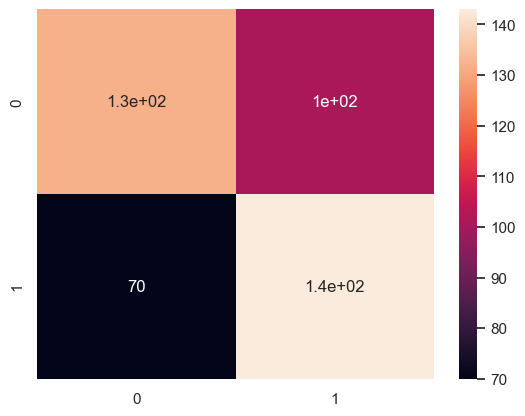

In [112]:
model_bayes = LogisticRegression(C = 4, max_iter = 250, solver = 'lbfgs', random_state=33)
model_bayes.fit(X_train_3, y_train_3)

y_pred_bayes = model_bayes.predict(X_test_4)

end = time.time()
execution_time = end - start
print(f"Tiempo de ejecución: {execution_time} segundos")

accuracy5 = accuracy_score(y_test_4, y_pred_bayes)
conf_matrix5 = confusion_matrix(y_test_4, y_pred_bayes)
classification_rep5 = classification_report(y_test_4, y_pred_bayes)

print(f"Accuracy: {accuracy5:.4f}")
print("\nConfusion Matrix:")
sns.heatmap(conf_matrix5, annot = True)
print("\nClassification Report:")
print(classification_rep5)

Con este método buscamos optimizar también la métrica de 'accuracy'. Como en los otros casos, los resultados no han mejorado, de hecho, han seguido siendo exactamente los mismos que en los últimos tres modelos. Por otro lado, y como era de esperar, con el método bayesiano la ejecución del modelo ha sido mucho más lenta, en este caso han sido 182 segundos, mucha diferencia con respeto los otros modelos.

Si que es interesante, observar como los parámetros usados no siempre han sido los mismos.

1. Grid Search - Mejores parámetros: 'solver': 'liblinear', 'max_iter': 50, 'C': 2
2. Random Search - Mejores parámetros: 'solver': 'newton-cg', 'max_iter': 1000, 'C': 5
3. Random Search 2- Mejores parámetros: 'solver': 'liblinear', max_iter : 2, 'C': 10
4. Bayes - Mejores parámetros: 'C': 4, 'max_iter': 250, 'solver': 'lbfgs'

Hemos ido usando distintos métodos de optimización de modelos y estos nos han usado resultado parametrizaciones distintas, aun así, la precisión obtenida siempre ha sido muy parecida. Es probable que esto signifique que este modelo no da mucho más de sí, es decir, que con la variable que me 'invente' en su momento, y viendo la poquísima separabilidad que hay entre clases, sea difícil sacar mejores resultados y hay diversas combinaciones de parámetros que nos dan buenos resultados.

# Clasificación Multiclase

Como los resultados no han sido los esperados y no he conseguido mejorar demasiado el modelo, he querido probar de optimizar algún otro modelo que habíamos visto en entregas anteriores para ver si podía optimizarlo.

Para ello, hace falta recuperar los datos y hacer un filtrado rapido similar al que ya hicimos en otra entrega.

In [113]:
nba_cleanest.head()

age  player_height  player_weight draft_round draft_number  gp   pts  reb  \
0  22.0         193.04      94.800728           2           42  64   3.9  1.5   
1  28.0         190.50      86.182480           2           34   4   3.8  1.3   
2  26.0         203.20     103.418976           1           12  41   8.3  6.4   
3  30.0         203.20     102.058200           1            7  64  10.2  2.8   
4  23.0         213.36     119.748288           1           22  52   2.8  1.7   

   ast  net_rating  oreb_pct  dreb_pct  usg_pct  ts_pct  ast_pct  season  
0  2.4         0.3     0.042     0.071    0.169   0.487    0.248      97  
1  0.3         8.9     0.030     0.111    0.174   0.497    0.043      97  
2  1.9        -8.2     0.106     0.185    0.175   0.512    0.125      97  
3  1.7        -2.7     0.027     0.111    0.206   0.527    0.125      97  
4  0.3       -14.1     0.102     0.169    0.195   0.500    0.064      97

In [114]:
# Reutilizamos el data set nba_cleanest y lo limpiamos

# Eliminamos jugadores con poco peso en la liga
condition_1 = nba_cleanest['gp'] > 41
condition_2 = (nba_cleanest['gp'] <= 41) & ((nba_cleanest['pts'] > 10) | (nba_cleanest['ast'] > 2.5) | (nba_cleanest['reb'] > 5))

nba_selected_players_multiclase = nba_cleanest[condition_1 | condition_2]
nba_selected_players_multiclase = nba_selected_players[nba_selected_players['gp'] >= 20]

len(nba_selected_players_multiclase)

9002

In [115]:
# Seleccionamos datos de los últimos años
nba_multiclase = nba_selected_players_multiclase[
    (nba_selected_players_multiclase['season'] == 19) |
    (nba_selected_players_multiclase['season'] == 20) |
    (nba_selected_players_multiclase['season'] == 21) |
    (nba_selected_players_multiclase['season'] == 22) |
    (nba_selected_players_multiclase['season'] == 23)
]

len(nba_multiclase)

1767

In [116]:
# Eliminamos variables innecesarias
nba_multiclase = nba_multiclase.drop(columns = ['age','player_height','player_weight','draft_number','dreb_pct','usg_pct','ast_pct','season'])

nba_multiclase

draft_round  gp   pts   reb  ast  net_rating  oreb_pct  ts_pct
10103           1  43   5.7   2.0  2.8        -8.5     0.012   0.417
10104           3  64  11.0   2.6  4.8         8.1     0.012   0.539
10105           1  48   5.8   2.2  1.1         3.7     0.023   0.528
10106           3  75   7.8   2.9  1.4        -1.6     0.014   0.543
10107           3  51   2.9   2.3  0.4         2.0     0.035   0.480
...           ...  ..   ...   ...  ...         ...       ...     ...
12837           3  46   6.9   2.8  3.3         2.5     0.012   0.616
12839           1  66  33.1  10.2  4.2         8.8     0.057   0.655
12841           1  71  13.1   6.5  1.2        -0.2     0.035   0.593
12842           2  52   3.4   4.7  0.5        -6.7     0.117   0.780
12843           3  57   6.4   3.6  0.9        -8.2     0.087   0.650

[1767 rows x 8 columns]

In [117]:
# Recordamos que teníamos tres observaciones que pertenecían a un mismo jugador 'undrafted', hace falta arreglarlo
nba_multiclase.loc[nba_multiclase['draft_round'] == '0', 'draft_round'] = '3'
nba_multiclase['draft_round'] = nba_multiclase['draft_round'].astype(int)


In [118]:
round1 = nba_multiclase[nba_multiclase['draft_round'] == 1]
round2 = nba_multiclase[nba_multiclase['draft_round'] == 2]
round3 = nba_multiclase[nba_multiclase['draft_round'] == 3]

print(len(round1))
print(len(round2))
print(len(round3))

1118
380
269


In [119]:
draft_1 = 1
draft_2 = 2
draft_3 = 3
reduced_1 = 0.75
reduced_2 = 0.25
reduced_3 = 0.01

indices1 = nba_multiclase[nba_multiclase['draft_round'] == draft_1].index
indices2 = nba_multiclase[nba_multiclase['draft_round'] == draft_2].index
indices3 = nba_multiclase[nba_multiclase['draft_round'] == draft_3].index

np.random.seed(33)

reduced1 = np.random.choice(indices1, size=int(len(indices1) * reduced_1), replace=False)
reduced2 = np.random.choice(indices2, size=int(len(indices2) * reduced_2), replace=False)
reduced3 = np.random.choice(indices3, size=int(len(indices3) * reduced_3), replace=False)


balanced_nba_multiclase = nba_multiclase.drop(set(reduced1).union(set(reduced2)).union(set(reduced3)))

round1 = balanced_nba_multiclase[balanced_nba_multiclase['draft_round'] == 1]
round2 = balanced_nba_multiclase[balanced_nba_multiclase['draft_round'] == 2]
round3 = balanced_nba_multiclase[balanced_nba_multiclase['draft_round'] == 3]

print(len(round1))
print(len(round2))
print(len(round3))

280
285
267


**Creamos un modelo con el Arbol de Clasificación:**

In [120]:
X_5 = balanced_nba_multiclase.drop(columns=['draft_round'])
y_5 = balanced_nba_multiclase['draft_round']

scaler = StandardScaler()
X_5 = scaler.fit_transform(X_5)

X_train_5, X_test_5, y_train_5, y_test_5 = train_test_split(X_5, y_5, test_size=0.2, random_state=33)

print('Training Data:', len(X_train_5))
print('Testing Data:', len(y_test_5))

Training Data: 665
Testing Data: 167


Tiempo de ejecución: 0.03372979164123535 segundos
Accuracy: 0.37

Confusion Matrix:

Classification Report:
              precision    recall  f1-score   support

           1       0.37      0.39      0.38        57
           2       0.34      0.31      0.33        65
           3       0.41      0.44      0.43        45

    accuracy                           0.37       167
   macro avg       0.37      0.38      0.38       167
weighted avg       0.37      0.37      0.37       167



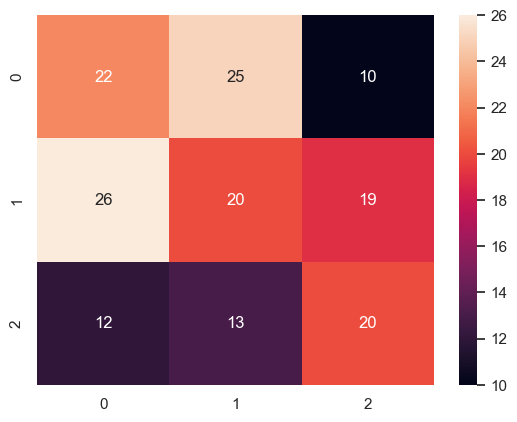

In [121]:
start = time.time()
arbol_nopar = DecisionTreeClassifier(random_state=33)
arbol1 = arbol_nopar.fit(X_train_5, y_train_5)

prediction = arbol1.predict(X_test_5)

accuracy = accuracy_score(y_test_5, prediction)
conf_matrix = confusion_matrix(y_test_5, prediction)
classification_rep = classification_report(y_test_5, prediction)

end = time.time()
execution_time = end - start
print(f"Tiempo de ejecución: {execution_time} segundos")

print(f"Accuracy: {accuracy:.2f}")
print("\nConfusion Matrix:")
sns.heatmap(conf_matrix, annot = True)
print("\nClassification Report:")
print(classification_rep)

Este es el modelo base, sin parametrizar. Es un modelo muy malo, pero creo que nos puede servir para aprender y ver el impacto de la optimización de modelos de una forma más clara que en el caso anterior, donde los resultados eran muy parecidos.

**Usaramos Grid Search para intentar mejorar el modelo:**

In [132]:
start_time = time.time()
model_params = {
    "criterion": ["gini", "entropy"],
    'max_depth': [10, 20, 30, 40],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 3, 4],
    "max_leaf_nodes": [50,100,500]
}

In [133]:
arbol_par = DecisionTreeClassifier(random_state=33)
gscv = GridSearchCV(arbol_par, model_params, cv = 5)
model_gs = gscv.fit(X_train_5, y_train_5)
print("Mejores parámetros:", model_gs.best_params_)

Mejores parámetros: {'criterion': 'gini', 'max_depth': 20, 'max_leaf_nodes': 50, 'min_samples_leaf': 4, 'min_samples_split': 2}


Tiempo de ejecución: 387.66871976852417 segundos
Accuracy: 0.46

Confusion Matrix:

Classification Report:
              precision    recall  f1-score   support

           1       0.47      0.46      0.46        57
           2       0.50      0.35      0.41        65
           3       0.41      0.60      0.49        45

    accuracy                           0.46       167
   macro avg       0.46      0.47      0.46       167
weighted avg       0.47      0.46      0.45       167



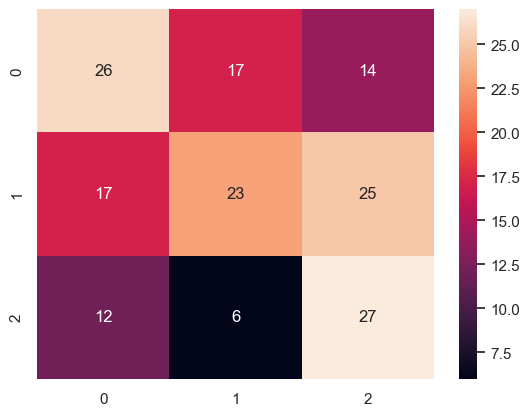

In [166]:
arbol_final = DecisionTreeClassifier(max_leaf_nodes=50, min_samples_split=4, criterion='gini', max_depth = 20, min_samples_leaf = 4)
arbol_final.fit(X_train_5,y_train_5)
prediction = arbol_final.predict(X_test_5)

end = time.time()
execution_time = end - start_time
print(f"Tiempo de ejecución: {execution_time} segundos")

accuracy = accuracy_score(y_test_5, prediction)
conf_matrix = confusion_matrix(y_test_5, prediction)
classification_rep = classification_report(y_test_5, prediction)

print(f"Accuracy: {accuracy:.2f}")
print("\nConfusion Matrix:")
sns.heatmap(conf_matrix, annot = True)
print("\nClassification Report:")
print(classification_rep)

Si bien es cierto que partíamos de valores muy bajos, la verdad es que la diferencia entre este modelo y el anterior es bastante grande. Hemos pasado de un 0,37 a un 0,46. En este caso las diferencias de precisión se ven mucho más claras. Por otro lado, las diferencias en tiempos de ejecución siguen siendo grandes, pero son más asumibles si la precisión mejora un 25%.

**Random Search**

In [150]:
start_time = time.time()
model_params = {
    "criterion": ["gini", "entropy"],
    'max_depth': [10, 20, 30, 40],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 3, 4],
    "max_leaf_nodes": [50,100,500]
}

In [151]:
arbol_par2 = DecisionTreeClassifier(random_state=33)
random3 = RandomizedSearchCV(estimator=arbol_par2, param_distributions=model_params, scoring='accuracy', cv=5, random_state=79, n_iter = 1000)

random3.fit(X_train_5, y_train_5)

print("Mejores parámetros:", random3.best_params_)

c:\Users\Marc\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_search.py:307: UserWarning: The total space of parameters 288 is smaller than n_iter=1000. Running 288 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Mejores parámetros: {'min_samples_split': 2, 'min_samples_leaf': 4, 'max_leaf_nodes': 50, 'max_depth': 20, 'criterion': 'gini'}


Tiempo de ejecución: 15.792112350463867 segundos
Accuracy: 0.46

Confusion Matrix:

Classification Report:
              precision    recall  f1-score   support

           1       0.47      0.46      0.46        57
           2       0.50      0.35      0.41        65
           3       0.41      0.60      0.49        45

    accuracy                           0.46       167
   macro avg       0.46      0.47      0.46       167
weighted avg       0.47      0.46      0.45       167



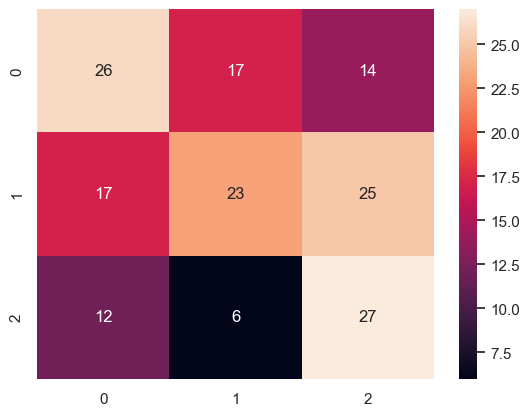

In [152]:
arbol_final = DecisionTreeClassifier(max_leaf_nodes=50, min_samples_split=2, min_samples_leaf = 4 ,criterion='gini', max_depth = 20)
arbol_final.fit(X_train_5,y_train_5)
prediction = arbol_final.predict(X_test_5)

end = time.time()
execution_time = end - start_time
print(f"Tiempo de ejecución: {execution_time} segundos")

accuracy = accuracy_score(y_test_5, prediction)
conf_matrix = confusion_matrix(y_test_5, prediction)
classification_rep = classification_report(y_test_5, prediction)

print(f"Accuracy: {accuracy:.2f}")
print("\nConfusion Matrix:")
sns.heatmap(conf_matrix, annot = True)
print("\nClassification Report:")
print(classification_rep)

En este caso los resultados son muy parecidos a los anteriores, vemos que la precisión del modelo es prácticamente idéntica, vemos que la 'accuracy' es de 0,46. En lo que se refiere al tiempo de ejecución, es un pelín más rápido que el anterior con 15 segundos, pero es una diferencia baja.

**Método Bayesiano**

In [163]:
start_time = time.time()
param_bayes2 = {
    "criterion": ["gini", "entropy"],
    'max_depth': np.arange(10, 50, 5),
    "min_samples_split": np.arange(2, 6),
    "min_samples_leaf": np.arange(1, 4),
    "max_leaf_nodes": np.arange(100, 1000, 100)
}

In [164]:
bayes = DecisionTreeClassifier(random_state=33)

bayes_search = BayesSearchCV(bayes, search_spaces = param_bayes2, scoring="accuracy", cv=5, n_jobs=-1)
np.int = int
bayes_search.fit(X_train_5, y_train_5)

print("Mejores parámetros:", bayes_search.best_params_)
print("Accuracy del mejor modelo en el entrenamiento:", bayes_search.best_score_)

Mejores parámetros: OrderedDict({'criterion': 'gini', 'max_depth': 30, 'max_leaf_nodes': 400, 'min_samples_leaf': 2, 'min_samples_split': 4})
Accuracy del mejor modelo en el entrenamiento: 0.4015037593984962


Tiempo de ejecución: 122.05404257774353 segundos
Accuracy: 0.40

Confusion Matrix:

Classification Report:
              precision    recall  f1-score   support

           1       0.43      0.46      0.44        57
           2       0.40      0.35      0.37        65
           3       0.38      0.40      0.39        45

    accuracy                           0.40       167
   macro avg       0.40      0.40      0.40       167
weighted avg       0.40      0.40      0.40       167



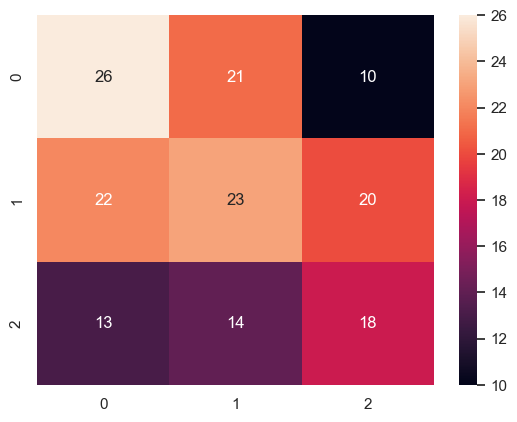

In [165]:
mejor_arbol = bayes_search.best_estimator_
prediction = mejor_arbol.predict(X_test_5)

end = time.time()
execution_time = end - start_time
print(f"Tiempo de ejecución: {execution_time} segundos")

accuracy = accuracy_score(y_test_5, prediction)
conf_matrix = confusion_matrix(y_test_5, prediction)
classification_rep = classification_report(y_test_5, prediction)

print(f"Accuracy: {accuracy:.2f}")
print("\nConfusion Matrix:")
sns.heatmap(conf_matrix, annot = True)
print("\nClassification Report:")
print(classification_rep)

Por último, he querido probar el método bayesiano, que no nos da los mejores resultados posibles (hemos visto en los casos anteriores que se puede obtener una 'accuracy' mayor a 0,40) y tampoco es el más eficiente, ya que el tiempo de ejecución es mucho más alto.

Merece la pena mencionar que este tiempo de ejecución es mayor en este caso, en parte porque he querido probar una nueva manera de introducir parámetros numéricos. He introducido rangos de parámetros asignando además las unidades con las que queremos ir avanzando a lo largo de estos rangos. De esta forma, el número de iteraciones es mucho mayor. Es con mucha diferencia el modelo más lento, ya que su tiempo de ejecución es de 122 segundos.

# Conclusiones

Después de un análisis extenso del dataset, de limpiarlo, valorar que hacer con algunos de sus outliers y de un estudio tanto de los componentes como de la información mutua, hemos empezado a intentar optimizar dos modelos que ya había creado en entregas anteriores. Esto se ha podido hacer gracias a tres métodos de optimización vistos en clase, el Grid Search, el Random Search y el método Bayesiano.

La primera opción ha sido optimizar una Regresión logística, un modelo clasificatorio que nos ayudaba a ver si los jugadores eran de primera o segunda ronda. Con este modelo hemos ido probando todos los métodos de optimización y la realidad es que nos ha costado muchísimo mejorar los resultados. La única mejora se puede observar en el caso del Grid Search pero es mínima.

Por otro lado, y viendo que no conseguía mejorar el anterior modelo, también he querido investigar sobre el modelo de Árbol de Decisión que cree para clasificar a los jugadores de 3 rondas del draft distintas (primera, segunda y no drafteados). El modelo era un dolor, ya que la clase tres es muy ambigua y la variable objetivo probablemente no era la mejor, pero en este caso si que hemos conseguido ver mejoras evidentes. Sobre todo con los métodos de Grid Search y de Random Search, la precisión del modelo pasa de 0,37 a 0,46.

Visto todo esto, la conclusión final es que parametrizar modelos no siempre es sencillo y, en muchos casos, pequeñas ganancias de precisión nos pueden costar muchísimo trabajo de ajustes en el propio modelo.

La realidad es que me hubiera gustado trabajar con modelos un poco mejores, pero la mayoría de los que he hecho con precisiones altas estaban sobre entrenando o claramente sesgados por el desbalance de los datos.

# Comentarios sobre la asignatura

Respecto a mi opinión sobre la asignatura, la verdad es que ha sido una pasada. Entre en el máster no sabiendo prácticamente nada, ni tan solo programar, y es verdad que en todas las asignaturas he ido aprendiendo algo porque era un libro en blanco, pero Sistemas Basados en el Conocimiento ha sido con mucha diferencia la asignatura que más me ha aportado hasta ahora y estoy muy agradecido por ello.

Gracias a esto, he empezado a atar cabos relacionando muchos conceptos vistos aquí con los de otras asignaturas y creo que es lo que más se agradece, ya que todo empieza a cobrar sentido.

Yo no había visto prácticamente nada de lo impartido, pero hablando con compañeros (y comparando con las explicaciones que nos han dado en otras asignaturas) me he dado cuenta de que no siempre se explica con tanta claridad y sencillez el funcionamiento de los algoritmos y la verdad es que esto ayuda mucho al seguimiento de las clases y prácticas.

Es difícil escoger lo que más me ha gustado, pero sí que tengo claro que la diferencia entre lo visto de enero hacia adelante y lo visto en 2023 es abismal, y siendo consciente que para perfiles como el mío, una buena base es importante, creo que sería ideal probar de comprimirlo y profundizar más durante las últimas 6 clases, aunque esto incluya más entregas. No lo sé, es solo una opinión porque personalmente he notado una gran diferencia.

Otro detalle que me gustaría comentar va relacionado con las entregas. Si bien es cierto que hay dos semanas por entrega, creo que el hecho de que se solapen hace que acabe siendo una sola semana. En mi opinión y por mi experiencia, creo que se podrían llegar a hacer entregas mejores con un pelín más de tiempo. Si bien es cierto que siempre se deja todo para el último momento, yo he intentado priorizar esta asignatura por encima de las demás, y aun así, se me ha quedado alguna idea en el tintero.

Y mi último comentario, también relacionado con las entregas, es que me hubiera gustado que la exigencia en las últimas dos hubiera sido igual de alta que en las otras dos. No hablo de exigencia al corregir, sino de un tema que también comentamos en clase en referencia a que la carga de trabajo en las dos últimas era más reducida. Entiendo que es un máster orientado a gente que trabaja, que nos explicasteis que otros años no funcionó, pero la verdad es que las primeras dos las sufrí con mucho placer y que en esta asignatura no me hubiera importado, sufrir 2 o 3 semanas más :)

Dicho todo esto, hacía tiempo que no me motivaba tanto una asignatura. Repito que me lo he pasado genial en clase, he aprendido muchísimo y creo que será difícil que ninguna asignatura de las que quedan supere la suma de explicación, entregas y contenido del que hemos disfrutado en Sistemas Basados en el Conocimiento.